## Notebook 02a: Understanding the sub-sevir Deep Learning Classification and Regression Models using SHAP


<div class="alert alert-block alert-danger"><b>Warning: </b> Before running this notebook, run the download_deep.ipynb notebook. That notebook will download the data and models used in this notebook. </div>


### Goal: Interogate the pre-trained classification and regression CNN models using SHAP

#### Background

In a [previous notebook](https://github.com/ai2es/tai4es-trustathon-2022/blob/main/severe/notebooks/Notebook_01a_ClassificationExplainability.ipynb), we interogated traditional ML models trained on manually engineered features from the sub-SEVIR dataset. We determined the top features, the relationships learned, and even explored explainability for individual predictions. For example, we found that spatial-maximum VIL and spatial-minimum IR temperature were the top features and the learned relationships matched with our physical intuition. In this notebook, we will try and understand convolutional neural networks that were trained on the identical tasks as the traditional ML models:
1. Does the image contain a lightning flash? 
2. How many lightning flashes are occuring in this image? 

The machine learning models here are trained as part of a paper that is in prep for WAF (Chase et al. "A Machine Learning Tutorial for Operational Meteorology, Part II: Neural Networks"). To be explicit, we assume the GOES Lightning Mapper (GLM) observations are unavailable and we need to use the other measurements (e.g., infrared brightness temperature) as features to estimate if there are lightning flashes (i.e., classification), and how many of them are there (i.e., regression).

These are the same tasks as [Chase et al. (2022)](https://arxiv.org/abs/2204.07492), so see that paper if you want perspective. We also discussed these ideas on slide 33 - 37 in the Day 2 slides. 



### Primary Tasks: 
1. Determine the important features
2. Use SHAP to explain the deep learning model 

### Seconday Tasks:
1. Explore different ways to visualize SHAP values
2. Compare the regression-based SHAP against the classification-based SHAP


In this notebook, you'll notice color-coded boxes, which may provide optional tasks, questions to discuss, or warnings. Here is the color-coding breakdown: 
* <span style="color:blue">Blue Box</span> = Question to discuss
* <span style="color:red">Red Box</span> = Warning/Caution
* <span style="color:gold">Yellow Box</span> = Optional task to perform 
* <span style="color:green">Green Box</span> = Useful Tip or Reminder


### Authors
* Randy Chase (OU/AI2ES) [email: randychase 'at' ou.edu; twitter: @dopplerchase]
* Montgomery Flora (CIWRO/NSSL) [email: monte.flora 'at' noaa.gov; twitter: @MontePhD]

### Import the neccesary third-party packages

In [1]:
#load model 
import tensorflow as tf 
import xarray as xr 
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd 
import shap
import cmocean

tf.compat.v1.disable_v2_behavior()

# Add ../scripts to our path so we can import functions from there.
import sys,os
sys.path.append('../scripts') 
from deep_util import get_group_idx, get_groups, show_sample, make_plot, standardanom
from util import unscale_data
from plotting_config import deep_display_feature_names, deep_color_dict
from deep_perm_imp import ImagePermI


from custom_metrics import *

#log the metrics so tensorflow can find them 
custom_objects = {'ConditionalMeanAbsoluteError': ConditionalMeanAbsoluteError,
                    'ConditionalMeanError': ConditionalMeanError,
                    'ConditionalRootMeanSquaredError':ConditionalRootMeanSquaredError,
                    'MeanError': MeanError,
                    'MaxCriticalSuccessIndex':MaxCriticalSuccessIndex}

Instructions for updating:
non-resource variables are not supported in the long term


### Load the data.

The data has been pre-split into training, validation, and testing datasets. We will load in the `sub-SEVIR` dataset here and plot an example image. The example image is a strong convective event with plenty of lightning.

divide by zero encountered in log10


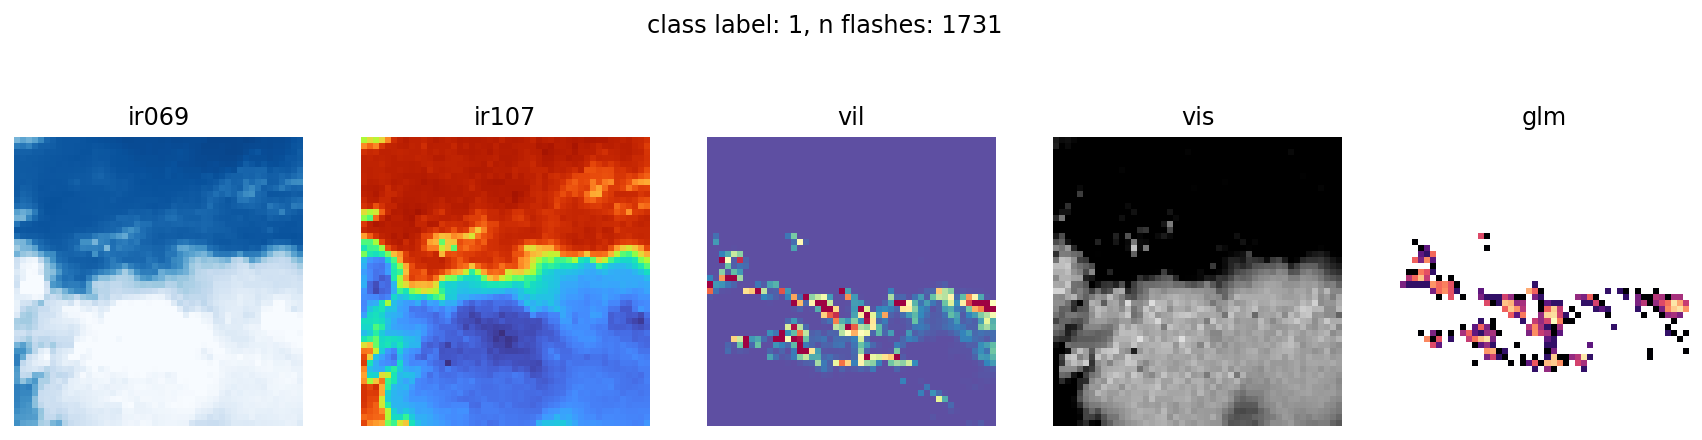

In [2]:
%config InlineBackend.figure_format = 'retina'

ds_train = xr.open_dataset('../datasets/sub-sevir-train.zarr', engine='zarr')
ds_val = xr.open_dataset('../datasets/sub-sevir-val.zarr', engine='zarr')
ds_test = xr.open_dataset('../datasets/sub-sevir-test.zarr', engine='zarr')

#choose 1 'storm' to show in examples
ds_sample = ds_val.isel(n_samples=ds_val.groupby('id').groups['S841009'])

#plot this example with a plotter function I have defined 
show_sample(ds_sample.isel(n_samples=11))

#store this image to do the XAI on 
im = ds_sample.isel(n_samples=11).features.values 

### Load the DL models.

Now that we have some data, let's load in the pretrained CNNs.

In [3]:
#classification model 
model_class = tf.keras.models.load_model('../models/sub-sevir-cnn-class-1d.h5',
                                                 custom_objects=custom_objects)

#need to remove sigmoid so XAI can see raw values 
model_class.layers[-1].activation = tf.keras.activations.linear

#regression model 
model_reg = tf.keras.models.load_model('../models/sub-sevir-cnn-reg-1d.h5',
                                                 custom_objects=custom_objects)

Instructions for updating:
Colocations handled automatically by placer.


2022-06-24 14:08:23.124884: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Task 1. Analyze the Important Features 

An initial task for understanding an ML model is understanding the important features – those features that contribute most to the model's performance. If the model performs well on independent data, then these features might provide insight into the data-generating process. The common approach for assessing feature importance is the permutation importance method. There are different flavors of permutation importance, which were covered in the lecture series. For this tutorial, we will only use the backward singlepass. 

### Classification 

The following cell will compute the backward singlepass permutation importance for the classification CNN model. Note that this may take a minute or two to run. To reduce the run time, you can set `subsample_size` to a lower value (e.g., 0.5 or 0.25)

In [4]:
X = ds_train.features.astype('float16').values[:,:,:,:]
y = ds_train.label_1d_class.astype('float16').values

# We are only using 75% of the training images to determine importance. 
# It is not neccesary to use the full training dataset since 
# we are generating bulk statistics. 
subsample_size=0.75

ip = ImagePermI(X, model_class, y, subsample_size=subsample_size)
ip.single_pass(direction='backward', metric='auc')

Shuffling Images, please wait...
done


`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:39<00:00,  9.82s/it]


Though we cannot compute permutation importance for deep learning models using skexplain, 
we can leverage built-in function that allows us to use the plotting functionality. The `to_skexplain_importance` function is designed to take any importance/relevance scores, rank them from high to low, and then convert it into a skexplain-friendly data format. 


In [5]:
import skexplain
from skexplain.common.importance_utils import to_skexplain_importance

# Since we are ranking from high to low, we need to convert the 
# permuted scores into importance scores
imp_scores = ip.start_score - ip.scores

# We set the method as 'backward_singlepass'. This is an expected name in skexplain and will
# help with the plotting. 

# to_skexplain_importance is expecting the data in 
# following shape (n_features, n_permutes). For this notebook, 
# we only performed one permutation so we need to convert imp scores to (n_features, 1)
results = to_skexplain_importance(
    importances=np.array([imp_scores]).T, 
    estimator_name='CNN', 
    feature_names=ds_train.n_channel.values,
    method='backward_singlepass', normalize=False
)

# Since we are using backward permutation importance we will want to include the
# original score which is used for comparison to measure importance. 
results['original_score__CNN'] = (('n_boot'), [ip.start_score])

# Lastly, it is easier to interpret the feature importances if we convert back to the permuted scores.
results['backward_singlepass_scores__CNN'] =  ip.start_score - results['backward_singlepass_scores__CNN']

(<Figure size 900x750 with 3 Axes>, <AxesSubplot:xlabel='AUC'>)

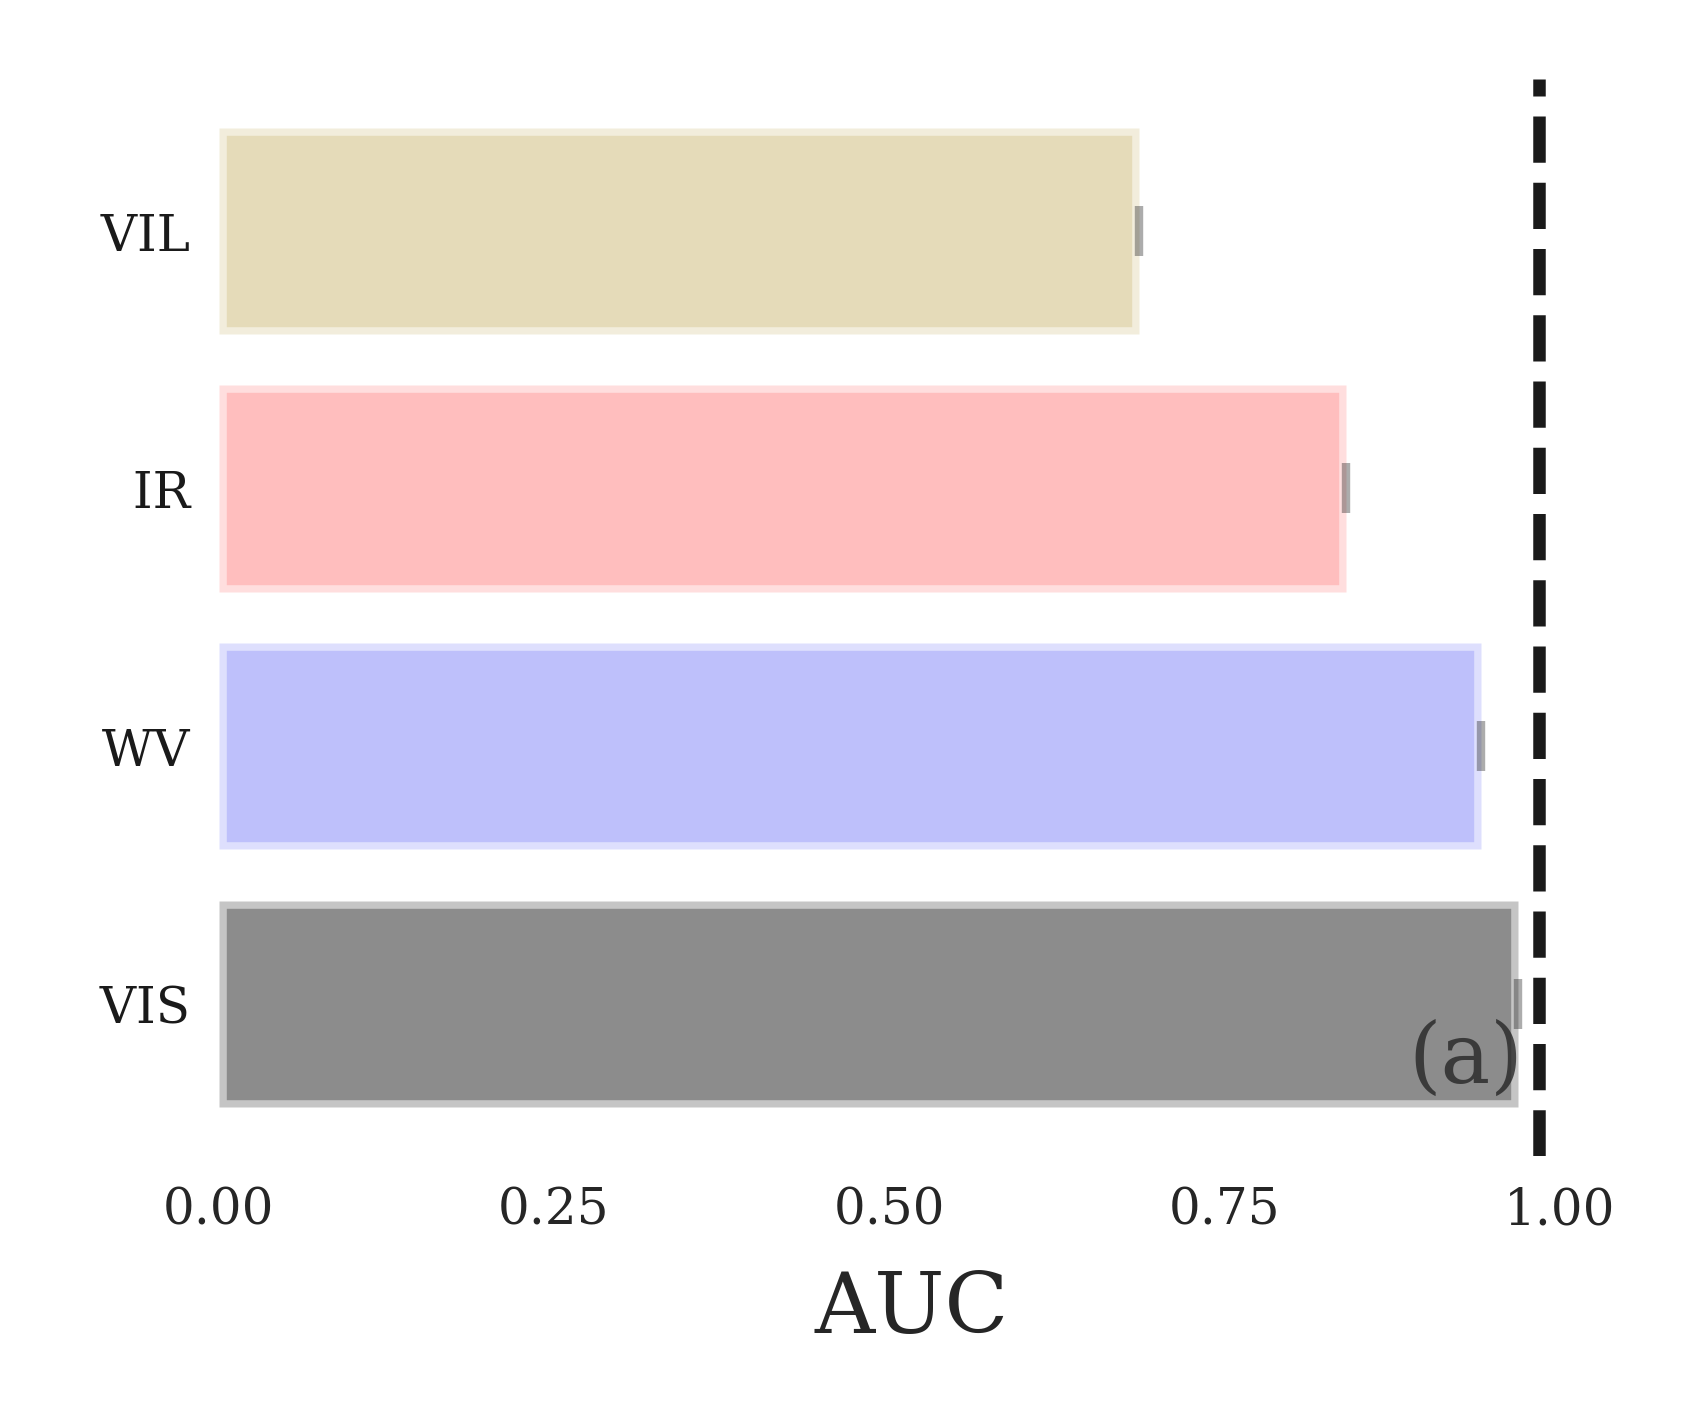

In [6]:
explainer = skexplain.ExplainToolkit()
explainer.plot_importance(results, panels = [('backward_singlepass', 'CNN')], 
                          xlabels=['AUC'], 
                          display_feature_names=deep_display_feature_names,
                          feature_colors=deep_color_dict)

The color coding is as follows: 
1. Red : Infrared (IR) brightness temperature-based features
2. Purple: Water vapor (WV) brightness temperature-based features
3. Gold: Vertically integrated liquid (VIL)-based features
    
<div class="alert alert-block alert-success"><b>Reminder about interpreting importance: </b> Permutation importance, whether backward or forward, is measure with respect to an original score. We measure importance with respect to original model performance for the backward method and with respect to all features being permuted for the forward method. For example, when permuted VIL has the greatest deviation from the original score and is thus the most important. </div>
  
For the classification CNN, the top feature was VIL, which is consistent with the traditional ML models. VIL and IR are plausible top features as high VIL values are associated with convective cores as are cold IR temperatures due to overshooting storm tops. Knowing that VIL and IR are the top 2 features we help us to interpret the SHAP values. 

### Regression

<div class="alert alert-block alert-warning"><b>Optional Task: </b> Convert the following section back to code and run it to see how the top features (according to backward singlepass) for the regression model compare against the classification model. </div>


<div class="alert alert-block alert-info"><b>Question 1 (optional): </b> How do the top features for the regression model compare against the classification model? If there is a difference, can you explain it? How would you explain the difference to your specific end-user for the trust-a-thon? </div>

## Task 2. Using SHAP to understand individual images

### Select background and initialize the SHAP explainer

SHAP needs training examples to learn the shap values from. To do this, we will give the shap python package 100 randomly sampled examples from the training dataset

In [7]:
#select a set of background examples to take an expectation over
rs = np.random.RandomState(123)

background = ds_train.isel(n_samples=rs.randint(0,ds_train.n_samples.shape[0],size=100))
background = background.features.values

# explain predictions of the model on four images
class_explainer = shap.DeepExplainer(model_class, background)
reg_explainer = shap.DeepExplainer(model_reg, background)

### Strong Convection Example

### i. Classification
Below the shap values for the classification model for the deep convective event we chose. This is a confident prediction from the model, with an output probability of effectively 1 (i.e., 100% confident there is lightning in the image)

### Using different SHAP scales per variable

The `make_plot` function plots the original images with the SHAP values overlaid. To improve the visualizations, we can use `mask_thresh` to only highlight higher SHAP values. Additionally, we can specify whether we want to have a single color scale for each variable or a different one per variable. Setting `normalize=True`, we will produce a single colorbar, which is shown later below. 

In this first example, we will highlight the different SHAP value scales per variable. VIL has the highest SHAP values while WV and VIS are lower contributors. This is consistent with the permutation importance results as WV and VIS were found to be least important features. In general, the larger SHAP values for all four variables are co-located with the cloudy regions.  While there is not a coherent/simple signal like "all cloud is positive information", it is good to see it is focusing on the cloud to predict if there was lightning in the image. Furthermore, you can see in panel 3 (VIL), the CNN again has located where the data are, and in general it looks like the higher intensity pixels of VIL are contributing towards lightning being in the image, as expected.

<div class="alert alert-block alert-info"><b>Question 2: </b> IR was the second most important, but the highest SHAP values are not located with coldest IR temperatures (look at the dark blue region in the IR panel)? What does that tell us about the model? Is this a potential failure mode? Is there a compenstating effect with VIL occurring? </div>

In [8]:
# Compute the classification SHAP values 
shap_values_class = class_explainer.shap_values(im[np.newaxis,:,:,:])[0][0]

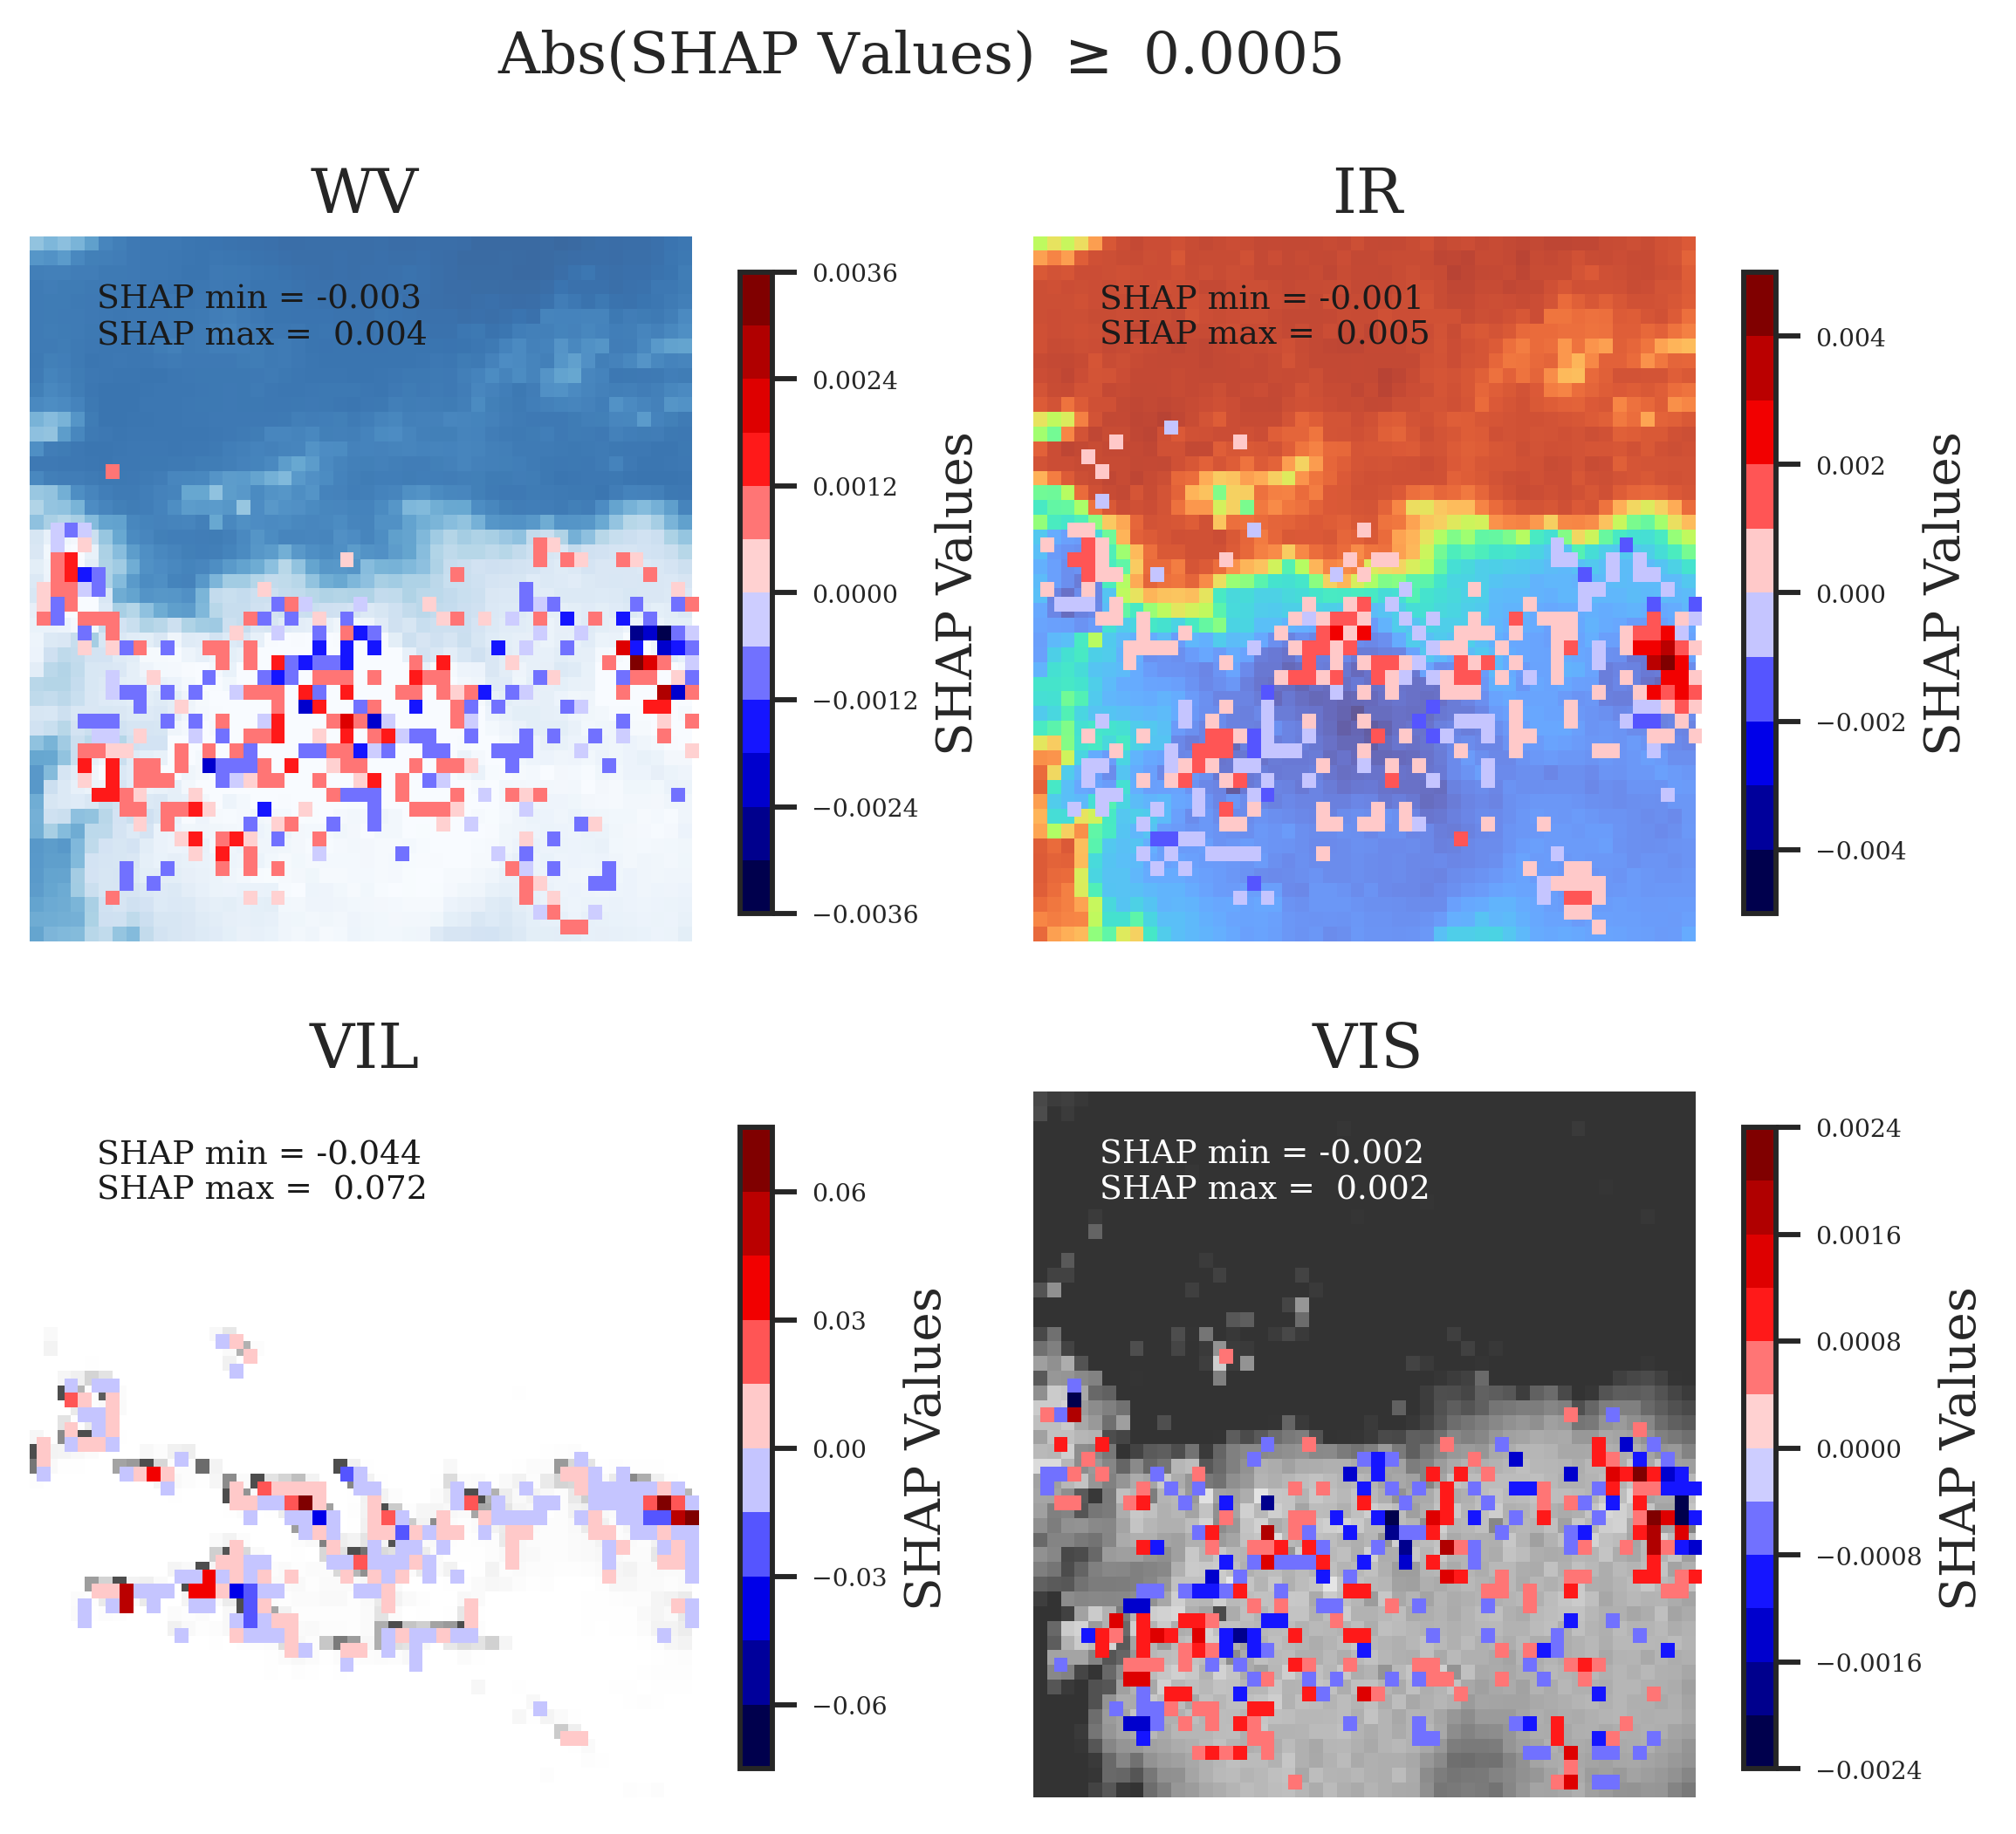

In [9]:
ax = make_plot(im, mask=shap_values_class, mask_thresh=0.0005)

### Using the same SHAP scale per variable

In this next example, we set `normalize=True` so we can evaluate the SHAP values on the same scale. Once we create a single scale, we can see that the VIL-based SHAP values are much larger than the other features and is driving most of the model prediction for this example.


<div class="alert alert-block alert-info"><b>Question 3: </b> Do you see any other patterns in the SHAP values? </div>



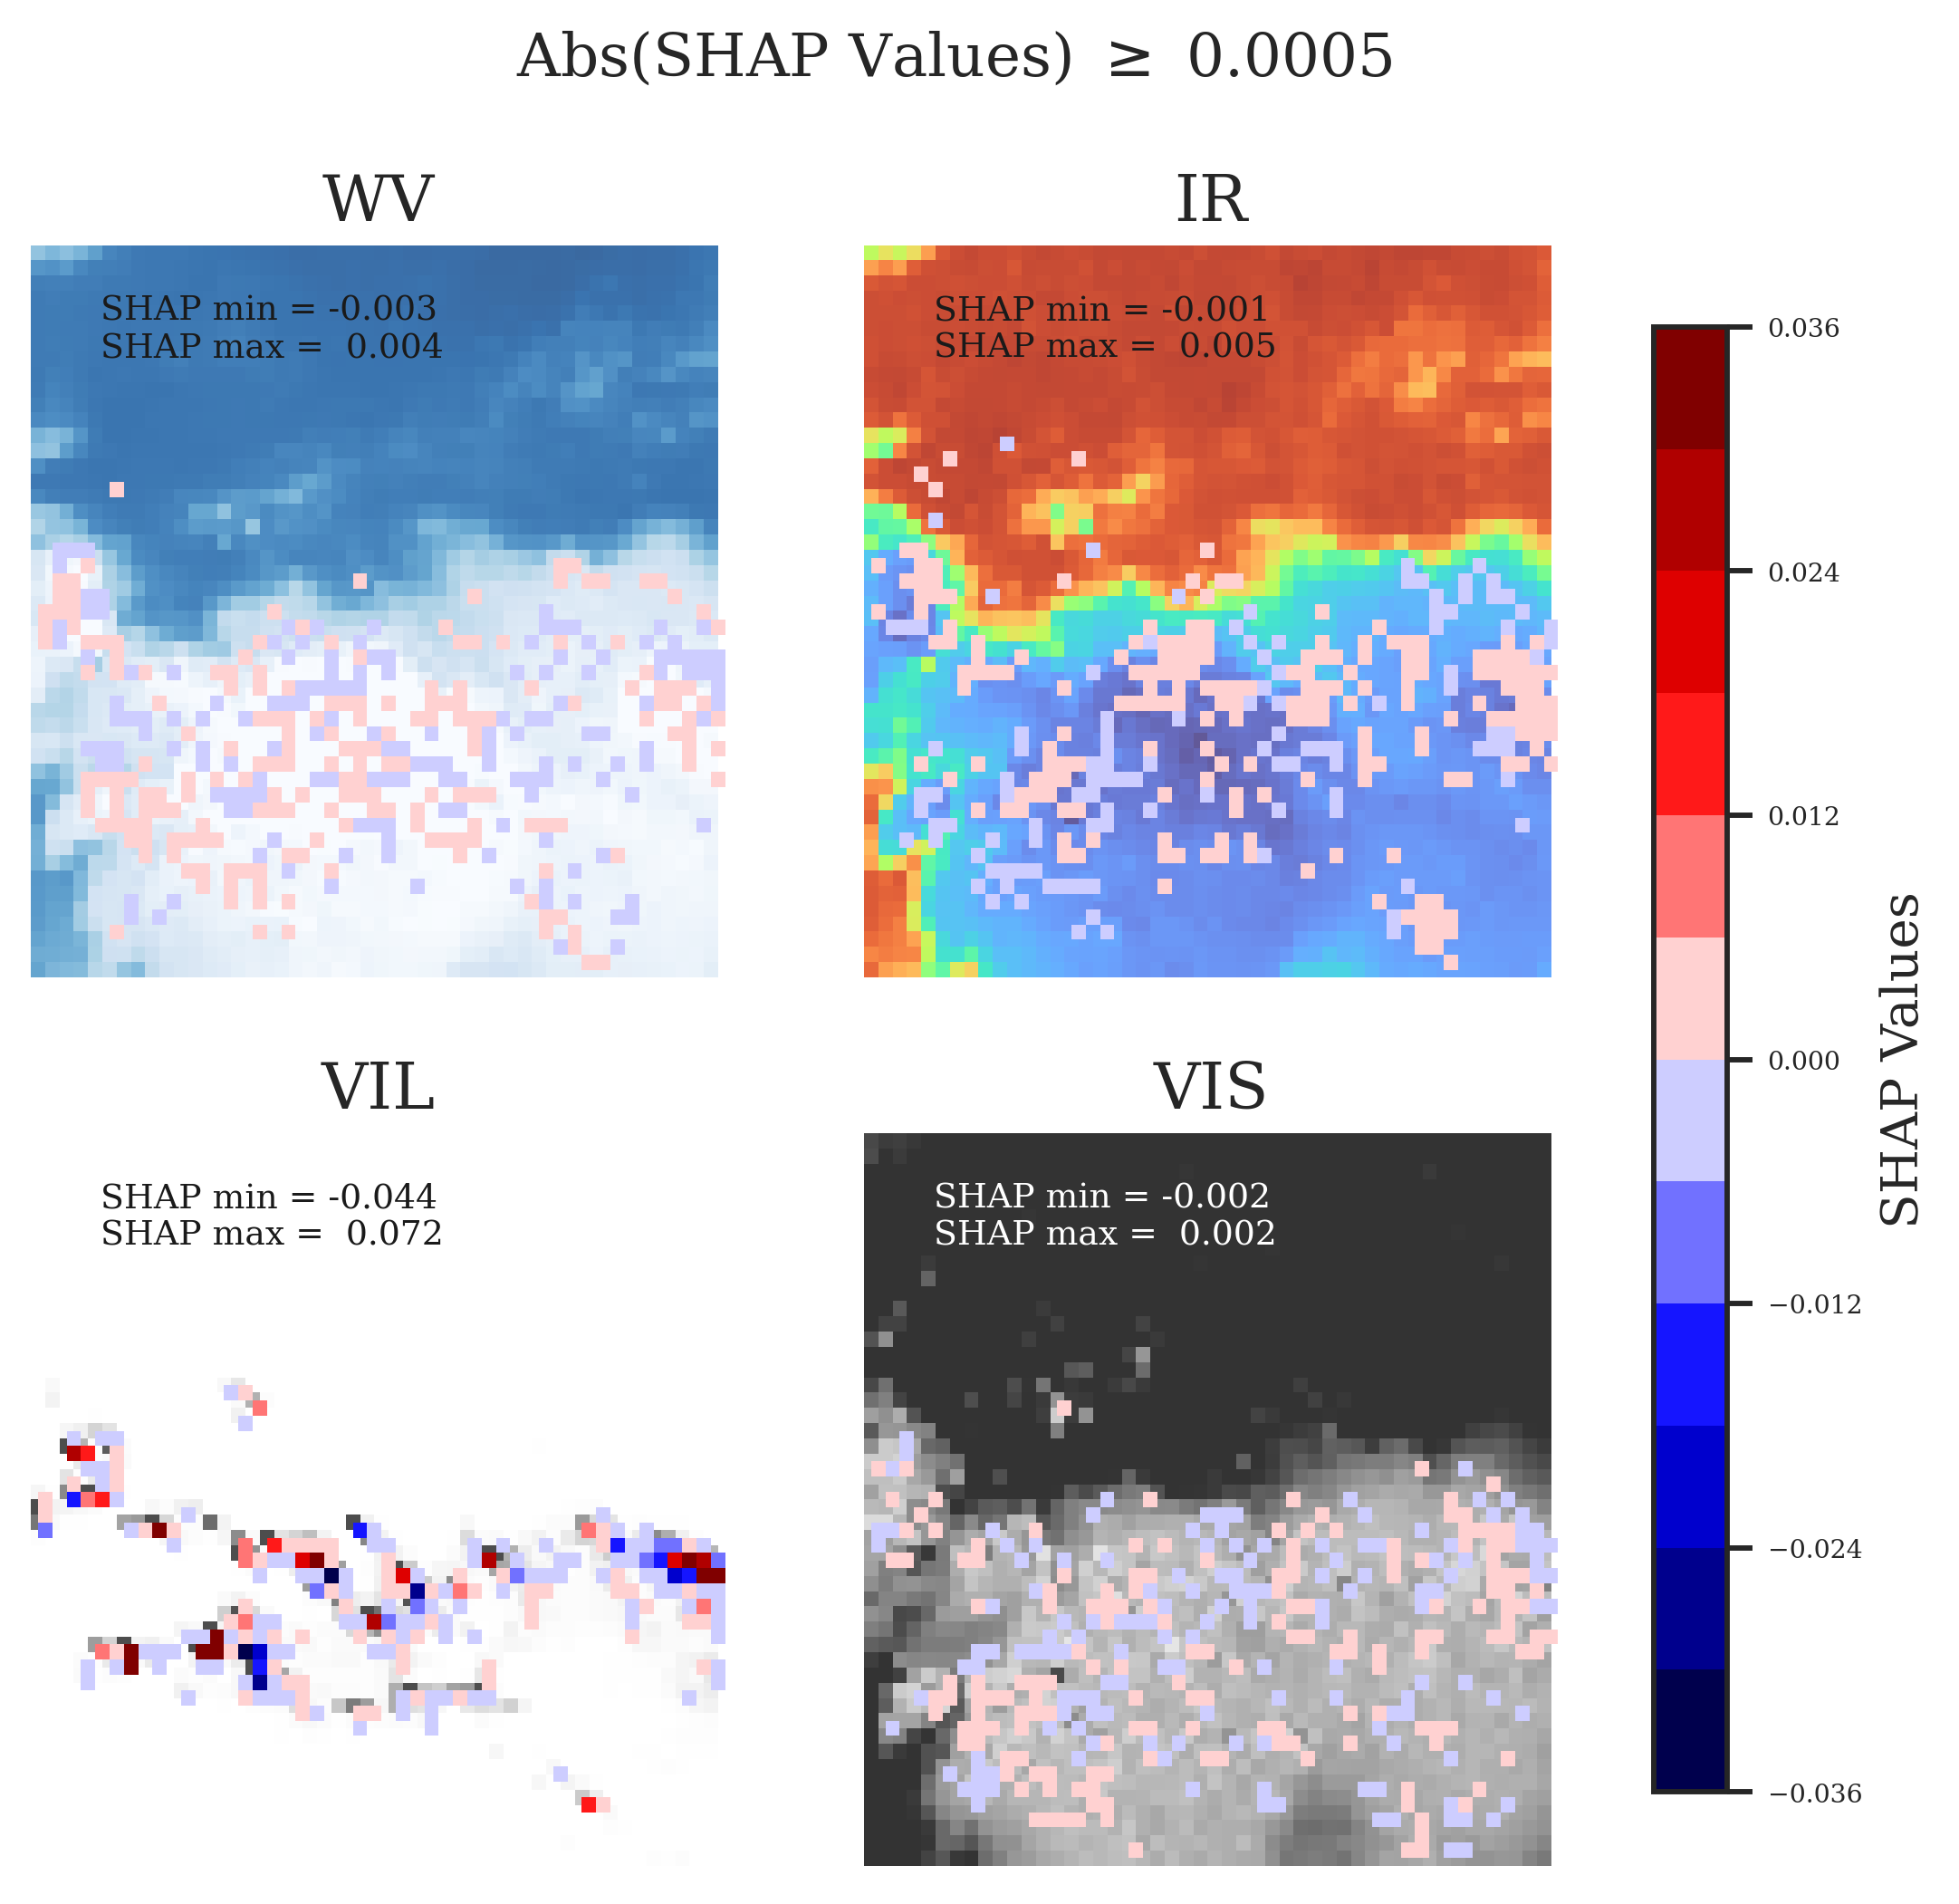

In [10]:
ax = make_plot(im, mask=shap_values_class, mask_thresh=0.0005, normalize=True)

<div class="alert alert-block alert-info"><b>Question 4: </b> How would you use this output to explain the model prediction to your specific end-user for the trust-a-thon? How would that change if you were explaining to the other end user for your dataset? How would you factor the different SHAP scales in your explanation? </div>

SHAP values have a nice property in that the expectation value plus the sum of all shap values provide the CNN output. So another way to visualize shap is to sum all channels together to see what pixels in the image are most important.

It should be clear here that since the summed shap basically outline the VIL, that the VIL seems to be the most important for this one prediction.

Like we mentioned in the previous text box, we can get the CNN output by summing the shap values and adding the expected value. 

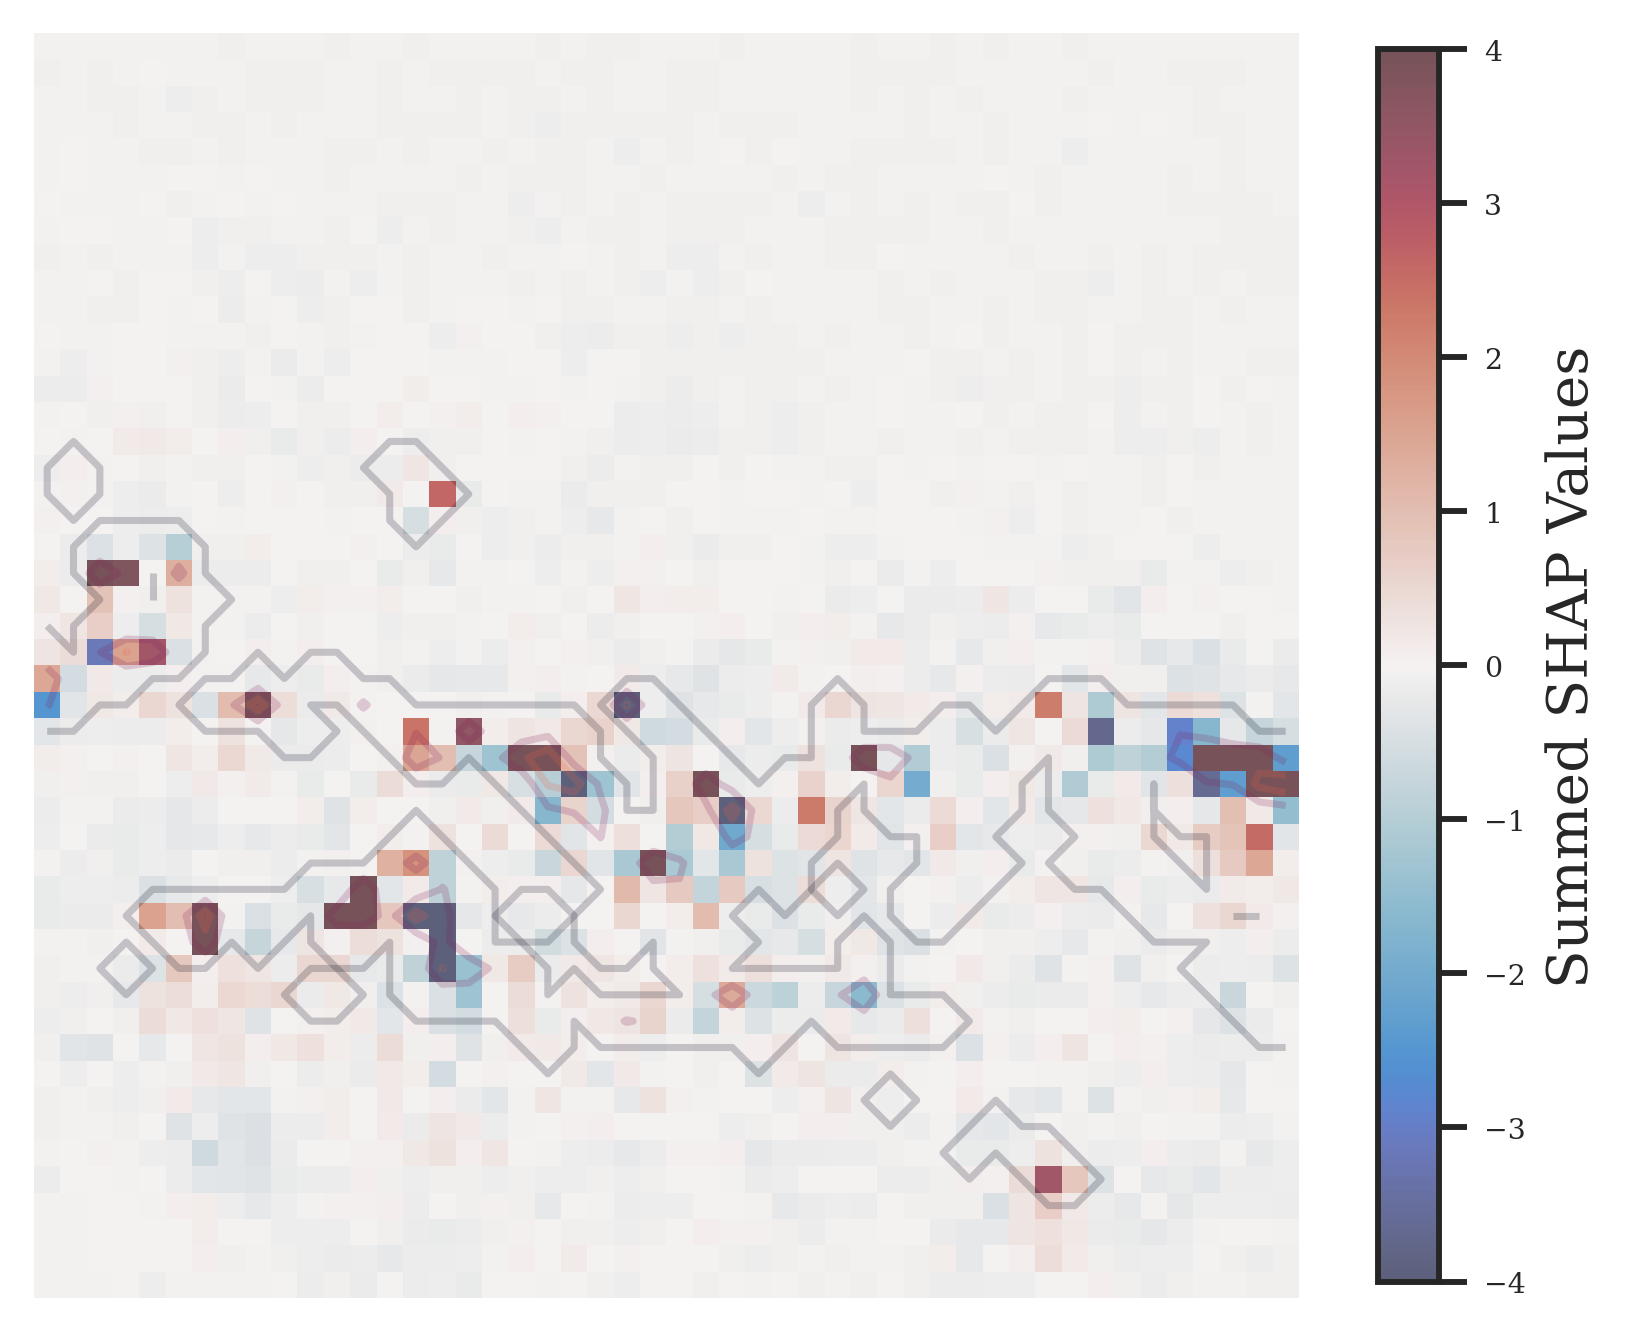

In [11]:
#by default it outputs channelwise results, so here we sum them together
shap_values_summed = np.sum(shap_values_class,axis=-1)
fig,axes = plt.subplots(figsize=[6, 6], dpi=170)
fig.set_facecolor('w')
mask = standardanom(shap_values_summed)
cf = axes.imshow(mask,cmap=cmocean.cm.balance,alpha=0.7,vmin=-4,vmax=4)

vil = np.where(im[:,:,2] < 1, 0, im[:,:,2])
axes.contour(vil, levels=2, alpha=0.2)

axes.axis('off')
fig.colorbar(cf, ax=axes, shrink=0.8, label='Summed SHAP Values')

In [12]:
shap_values_class.sum() + class_explainer.expected_value

array([0.9979435], dtype=float32)

## Exploring different ways to visualize the spatial SHAP values. 

### CDF Plot

In this section, we will explore different ways to visualize the spatial SHAP values.  In this first example, we compute the CDF of the SHAP values for each feature. The final value is the total contribution from that feature. 

<div class="alert alert-block alert-success"><b>Reminder:</b> To re-iterate the expected value (the average model prediction value) plus the SHAP values from each feature equals the model prediction. In this case, the VIL and IR make a large contribution to the model prediction. </div>

In [13]:
import copy
def cdf_plot(im, shap_values, explainer):
    fig = plt.figure(dpi=170)
    fig.set_facecolor('w')
    colors = np.array(['b','r','y','k'])
    labels = np.array(['WV','IR','VIL','VIS'])
    for i in np.arange(0,4):
        s_tmp = copy.deepcopy(shap_values[:,:,i].ravel())
        idx_to_sort = np.argsort(im[:,:,i].ravel())
        s_tmp = s_tmp.cumsum()
        plt.plot(explainer.expected_value + s_tmp,color=colors[i],label=labels[i])
        plt.plot(len(s_tmp),class_explainer.expected_value + s_tmp[-1],'o',
           color=colors[i],markerfacecolor='w')
        anno = str(np.round(s_tmp[-1],2))
        plt.text(len(s_tmp)+50,explainer.expected_value + s_tmp[-1]-0.005,
           anno, fontsize=7)
  
        anno = '$\mathrm{\mathbb{E}}[x]$:' + str(np.round(explainer.expected_value[0],2))

    plt.text(100, explainer.expected_value[0]+.01,
           anno, fontsize=10)
  
    plt.legend(loc=2)
    plt.ylabel('Cumulated SHAP Values')
    plt.xlabel('Number of Pixels')
    plt.xlim([0,len(s_tmp)+300])
    plt.title('Shap Image CDF')

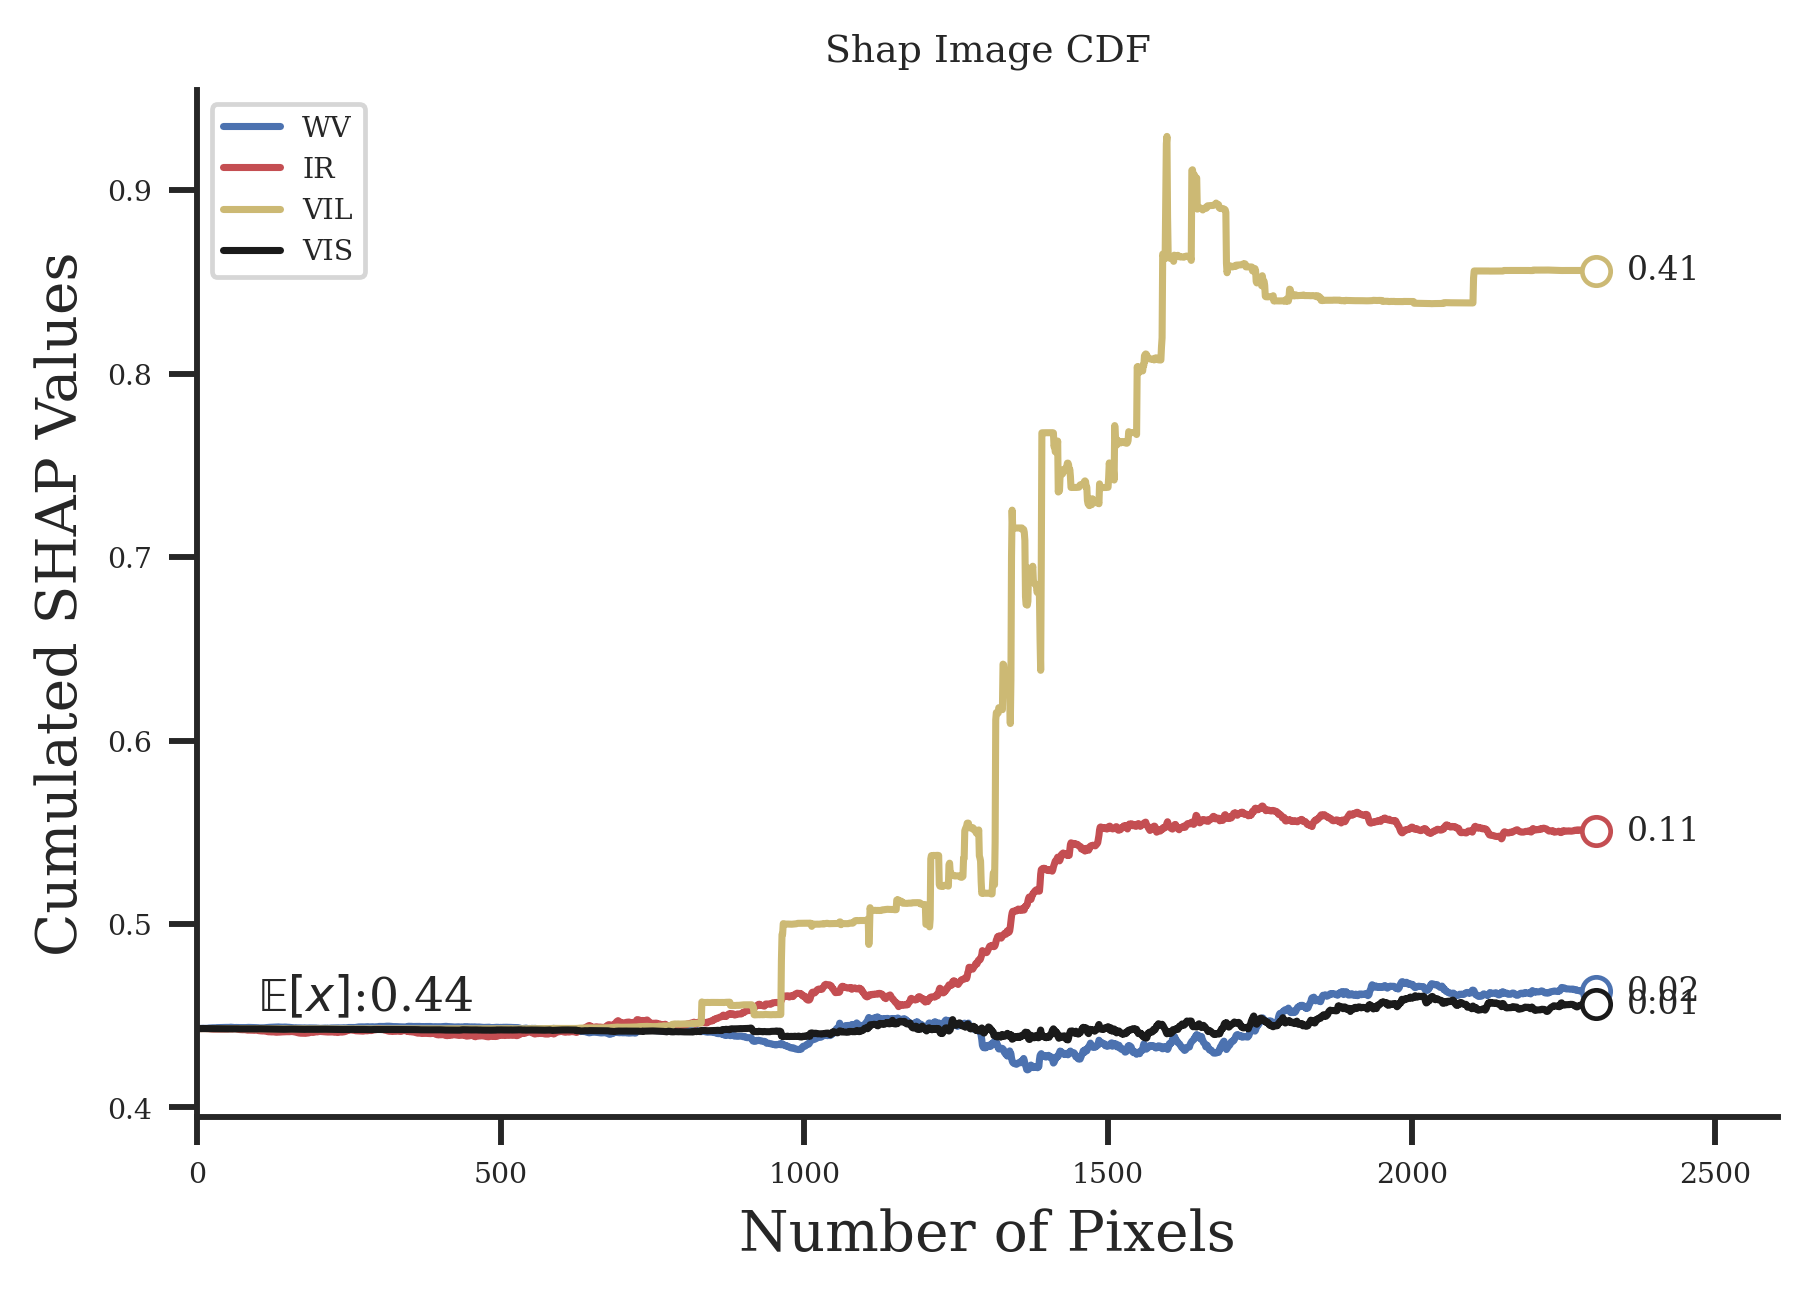

In [14]:
cdf_plot(im, shap_values_class, class_explainer)

\begin{equation}
P = 0.44 + 0.41 + 0.11 + 0.02 + 0.01 \approx 1.0
\end{equation}

<div class="alert alert-block alert-danger"><b>Caution: </b> You may get slightly different values than we've shown in the above summation. The SHAP values will still equal 1.0, but may slightly vary due to the approximate nature of the SHAP values.</div>

### Scatter Plot

In [15]:
import pandas as pd

def scatter_plot(im, shap_values):
    f,axes = plt.subplots(nrows=2, ncols=2, dpi=170)
    xlabels = ['WV', 'IR', 'VIL', 'VIS']
    names = ['wv', 'ir', 'vl', 'vi']
    df = pd.DataFrame(im.reshape((48*48, 4)), columns=names)
    im_unscaled = unscale_data(df).values

    for i, ax in enumerate(axes.flat):
        x = im_unscaled[:, i]
        y = shap_values[:,:,i]

        ax.scatter(x, y, s=3)
        ax.set_ylabel('SHAP Value')
        ax.set_xlabel(xlabels[i])
        ax.grid()
    
    plt.tight_layout()

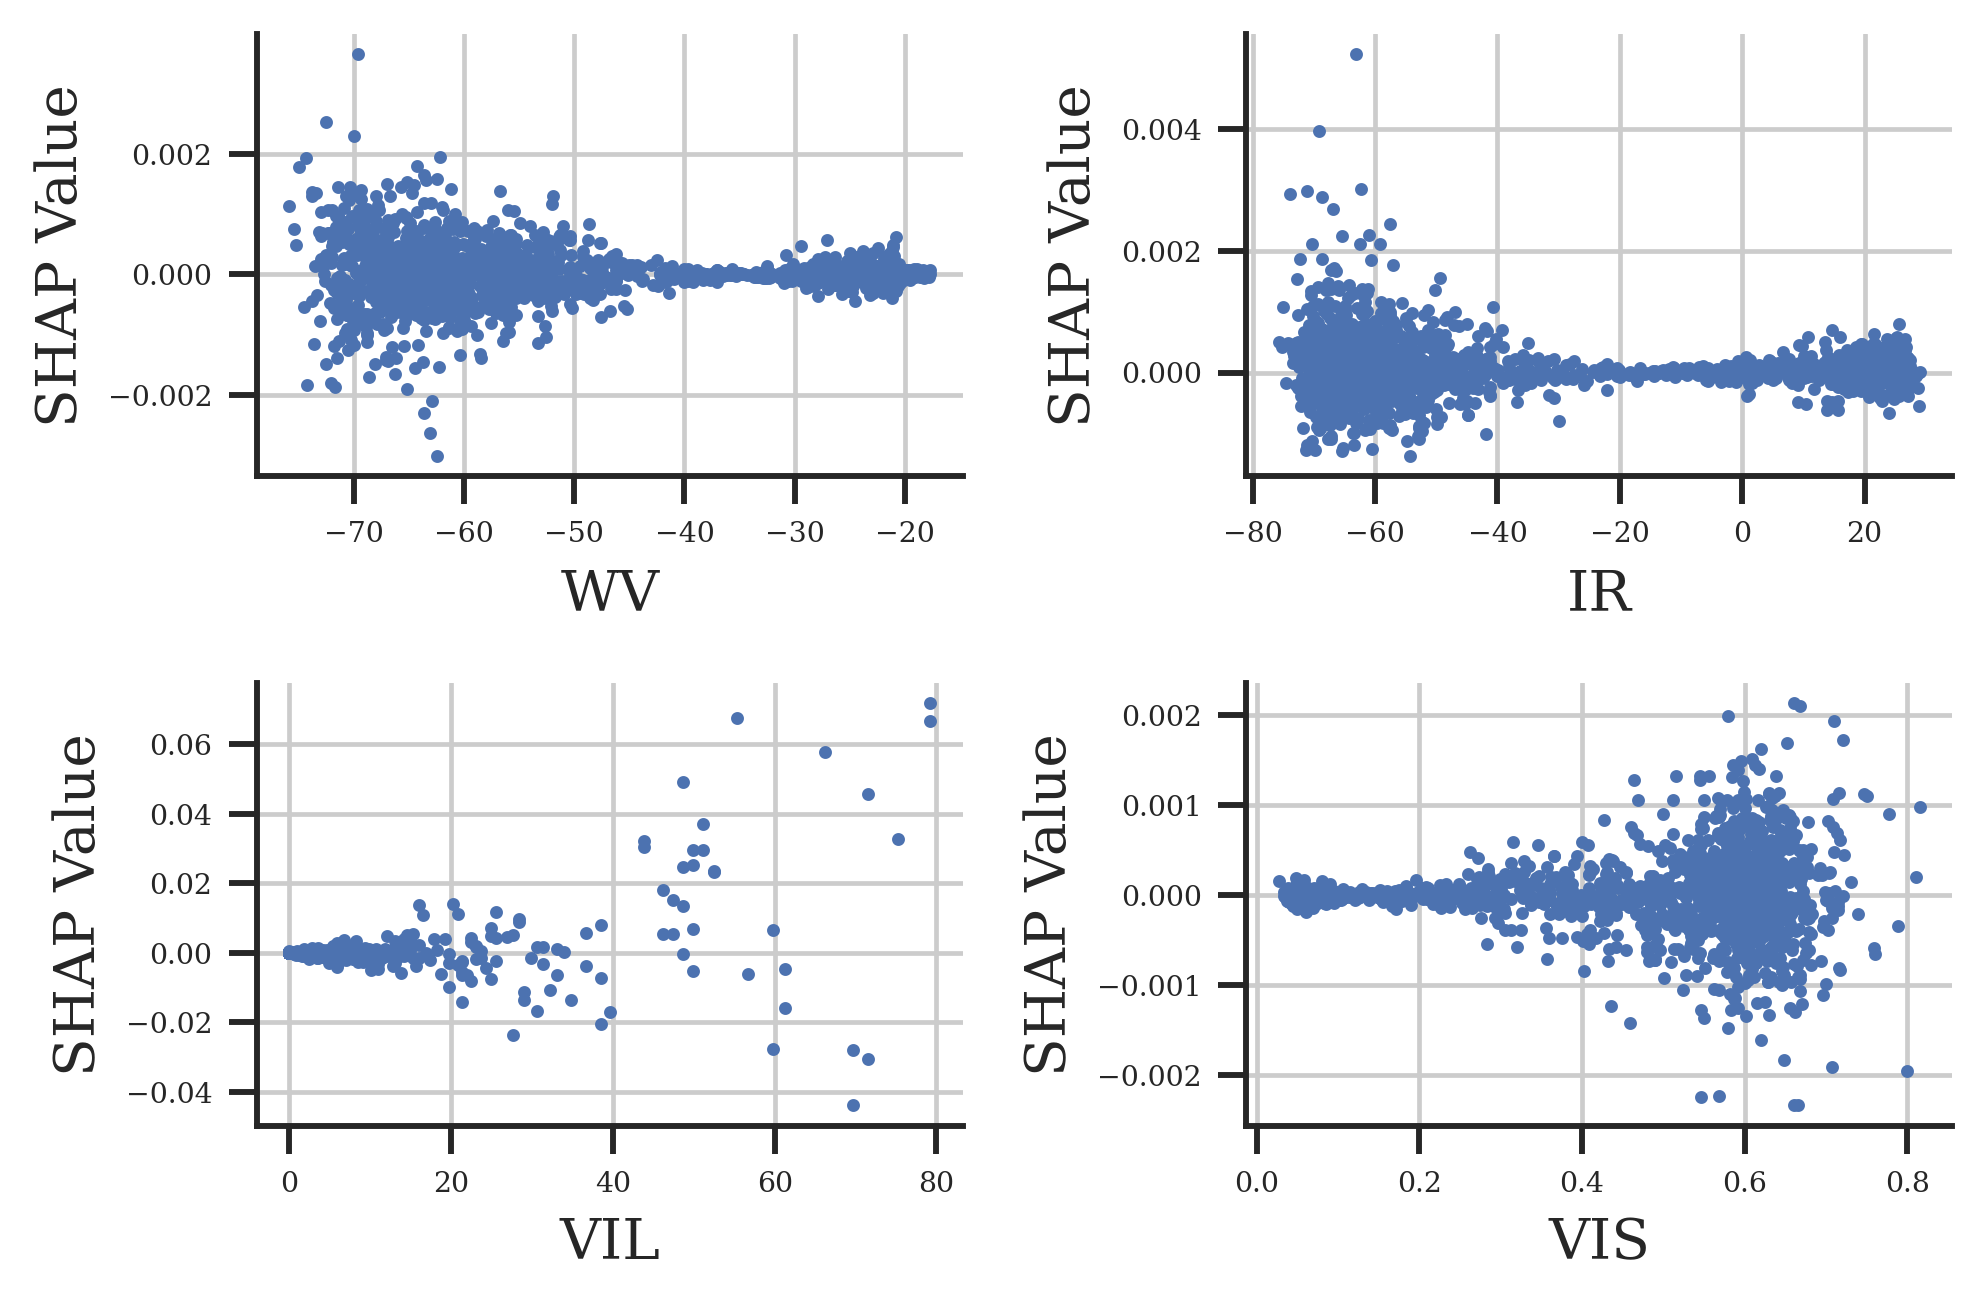

In [16]:
scatter_plot(im, shap_values_class)

Using a scatter plot, we can better evaluate the relationship between the SHAP values and the values of a given variable. We see that the SHAP values become largely positive once the VIL > 20 or when IR < -40. In the traditional ML models, we found that these same approximate thresholds for VIL and IR held true for the positive/negative ALE values. This suggests that the CNN model and the traditional ML models are consistent with each other. 


<div class="alert alert-block alert-info"><b>Question 5: </b> Do you find these additional visuals useful/helpful? Would these additional visuals help you to explain the model to your specific end-user? </div>

<div class="alert alert-block alert-warning"><b>Optional Task: </b> Find an additional way to visualize the SHAP values. </div>


### ii. Regression

Now we do the same type of analysis for the regression model.

<div class="alert alert-block alert-warning"><b>Optional Task: </b> Convert the following section back to code and run it to see how the SHAP values compare against the classification model for the same example. </div>

cdf_plot(im, shap_values_reg, reg_explainer,)

scatter_plot(im, shap_values_reg)

The end result is similar, but it is slightly different.

reg_explainer.expected_value + np.sum(shap_values_reg)

## No Storm Example

As a contrasting example, we can consider a satellite image with very little meteorological activity. When little meteorological activity is present, we would anticipate the model prediction is low and given that the expected rate is ~50%, we would expect the SHAP values to be largely negative. 

divide by zero encountered in log10


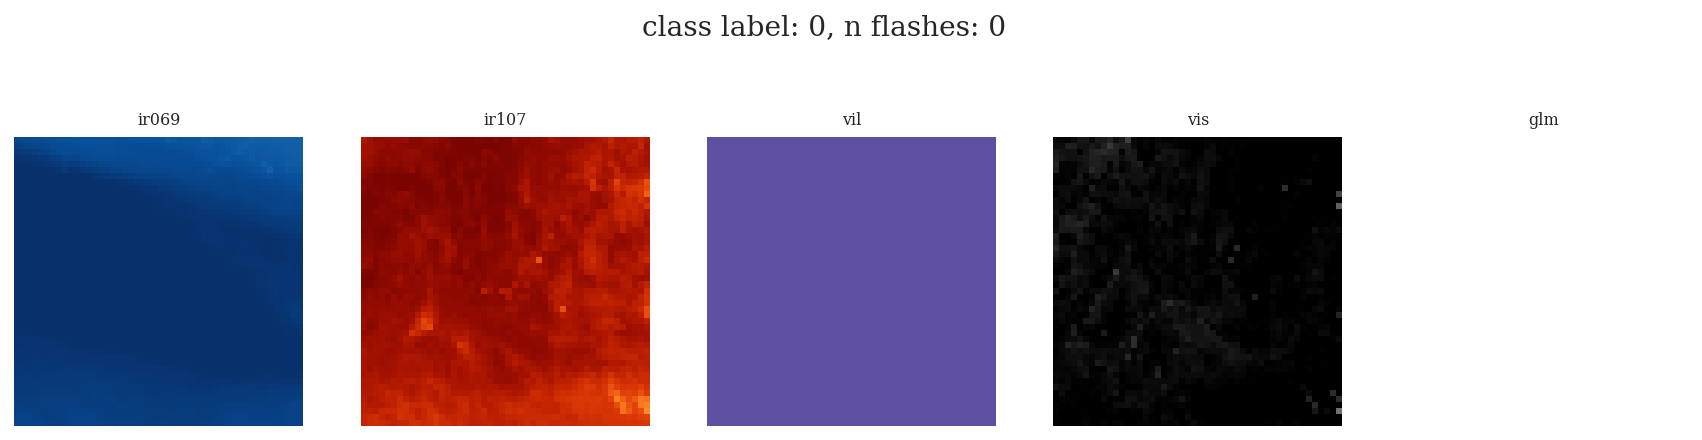

In [17]:
#choose 1 'storm' to show in examples
ds_sample = ds_val.isel(n_samples=ds_val.groupby('id').groups['R19072715377489'])

show_sample(ds_sample.isel(n_samples=0))

#store this image to do the XAI on 
im = ds_sample.isel(n_samples=0).features.values 

### i. Classification
Below the shap values for the classification model for the no lightning event we chose. This is a confident prediction from the model that there is no lighting, the prediction is effectively 0. 

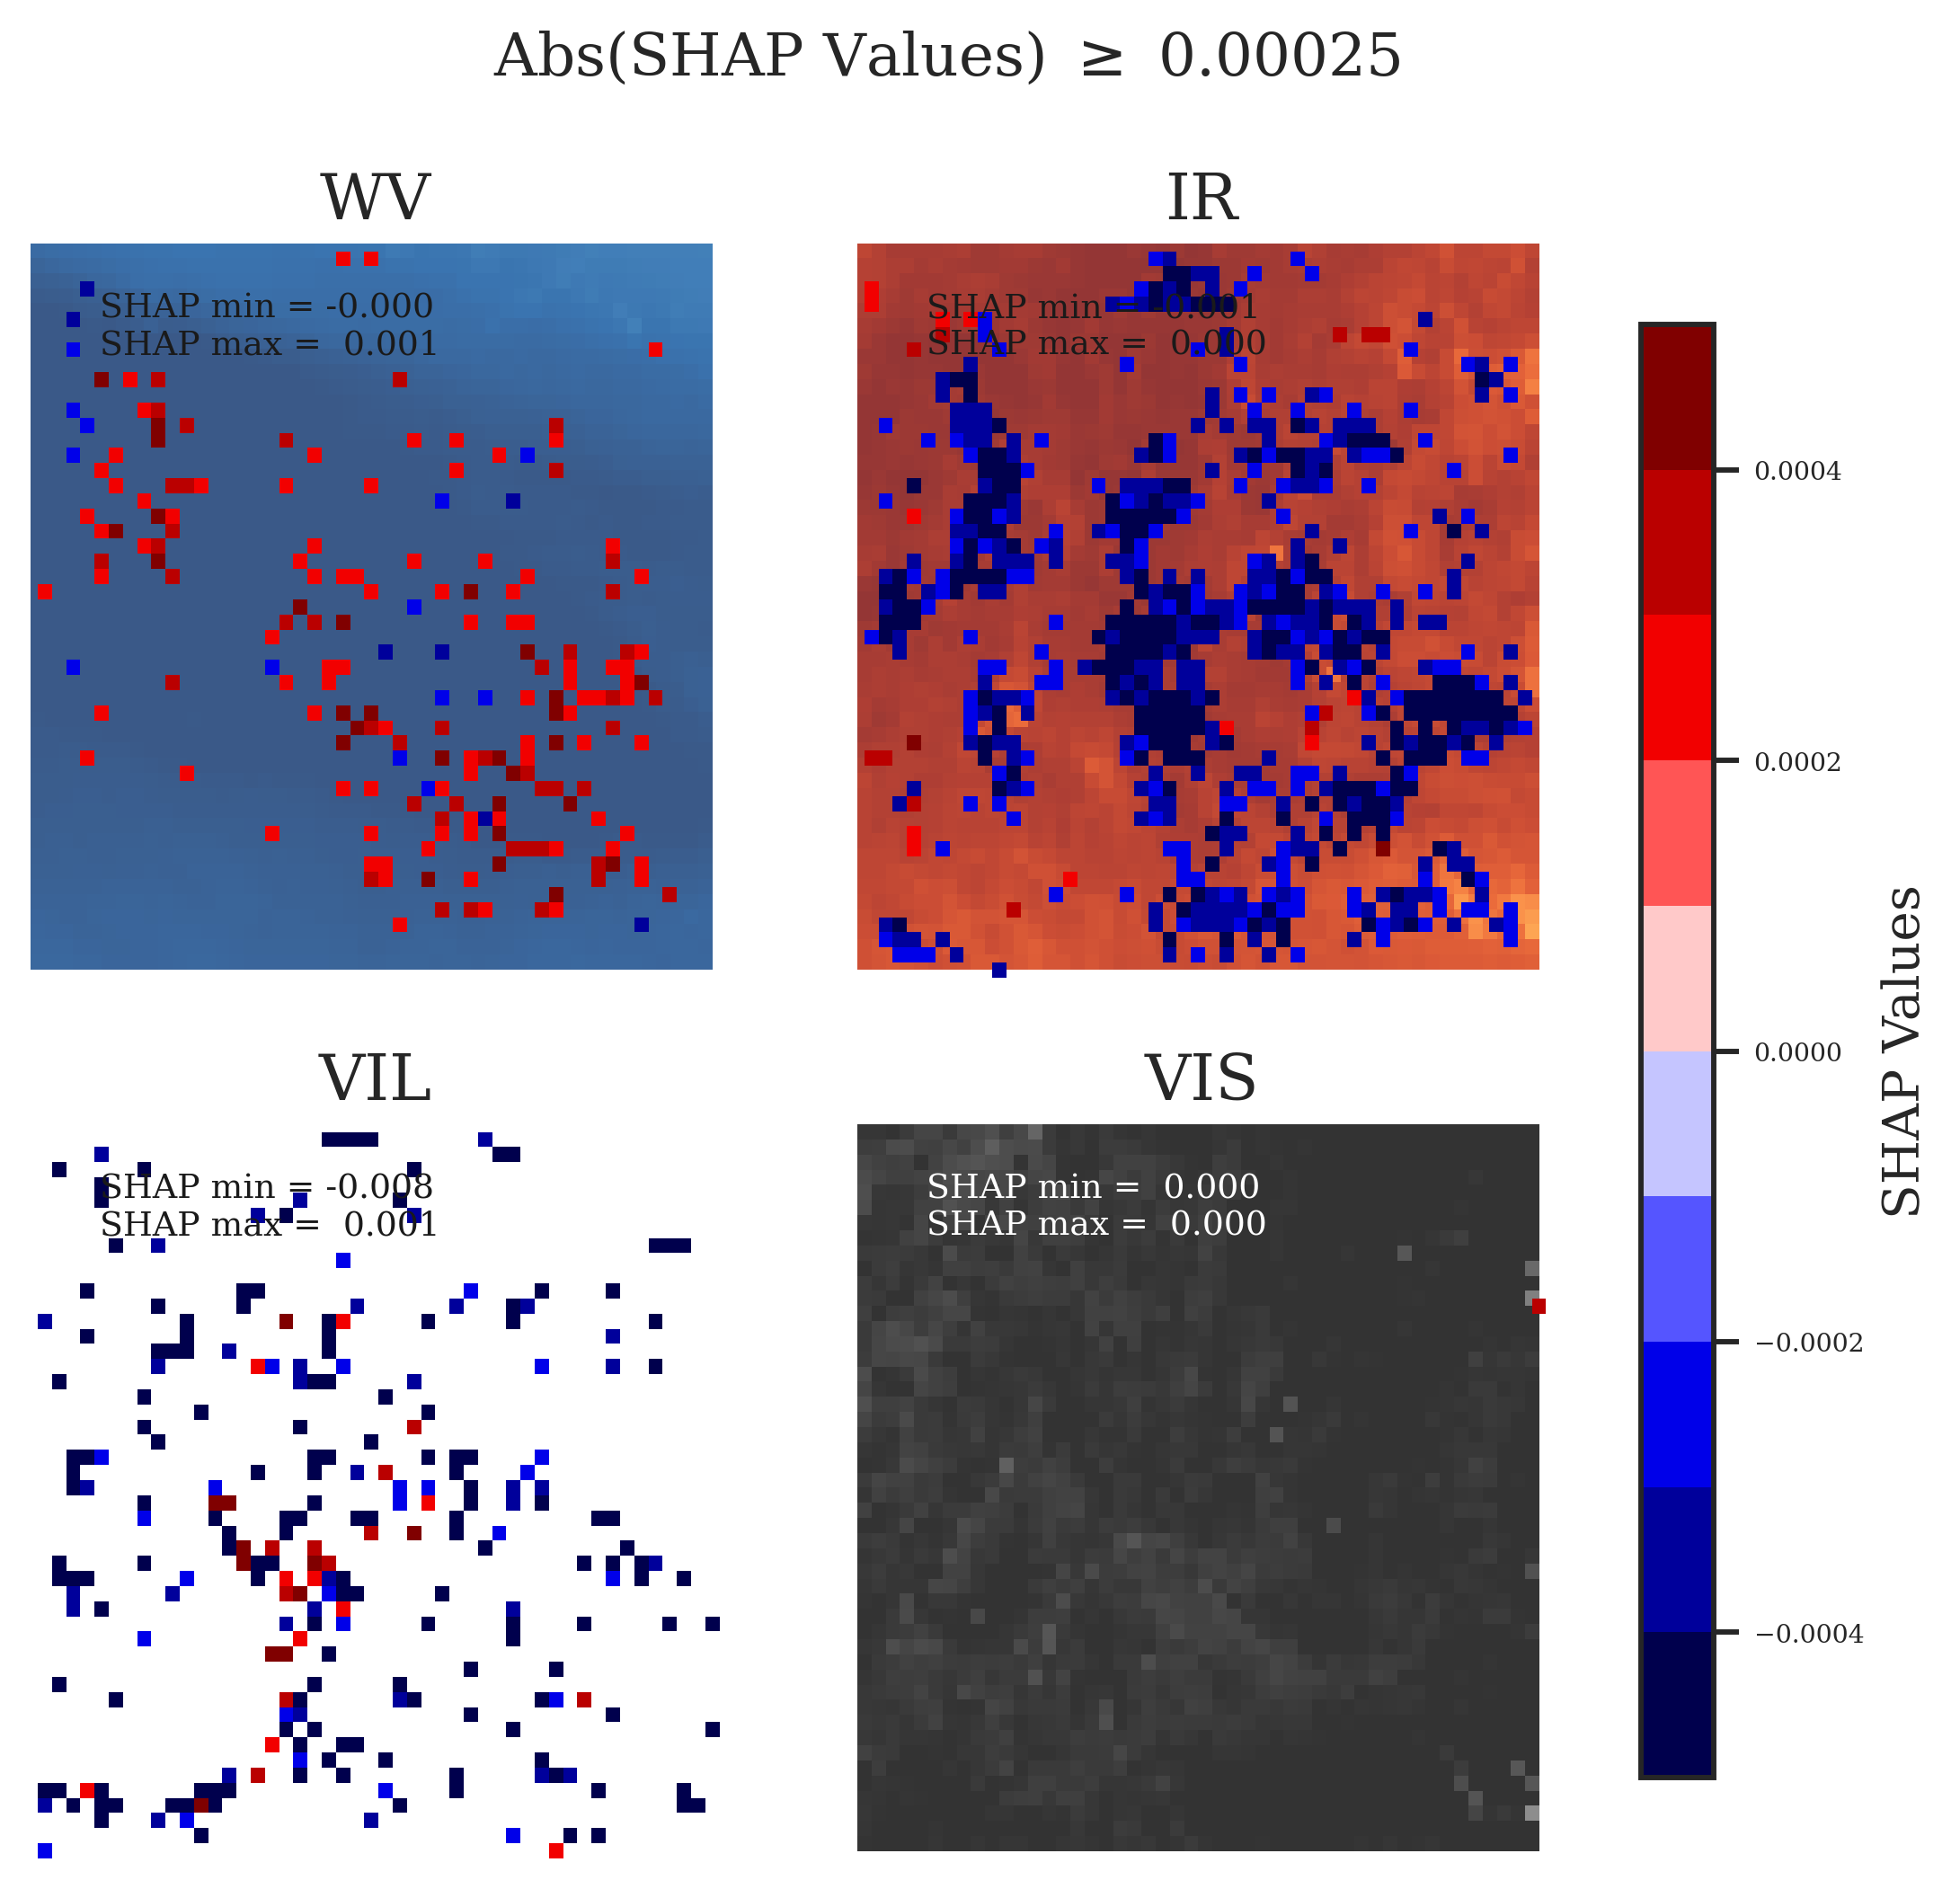

In [18]:
shap_values_class = class_explainer.shap_values(im[np.newaxis,:,:,:])[0][0]
ax = make_plot(im,mask=shap_values_class, normalize=True, mask_thresh=0.00025)

It is a good sanity check that SHAP values are fairly low for this non-storm image. In genernal, the CNN is not focusing on any specific region. However, we can see that the warm IR temperatures are largely associated with negative SHAP values. When we compute the cumulated SHAP values, we can see that the warm IR temperatures are making the largest contribution. One potential issue is that WV is making a decent positive contribution despite the lack of a clear WV signal. 

<div class="alert alert-block alert-info"><b>Question 6: </b> What do you think is leading to the positive contribution from WV? Is this something you may need to explain to your specific end-user? Is this a potential failure mode or simply a compensating effect? </div>



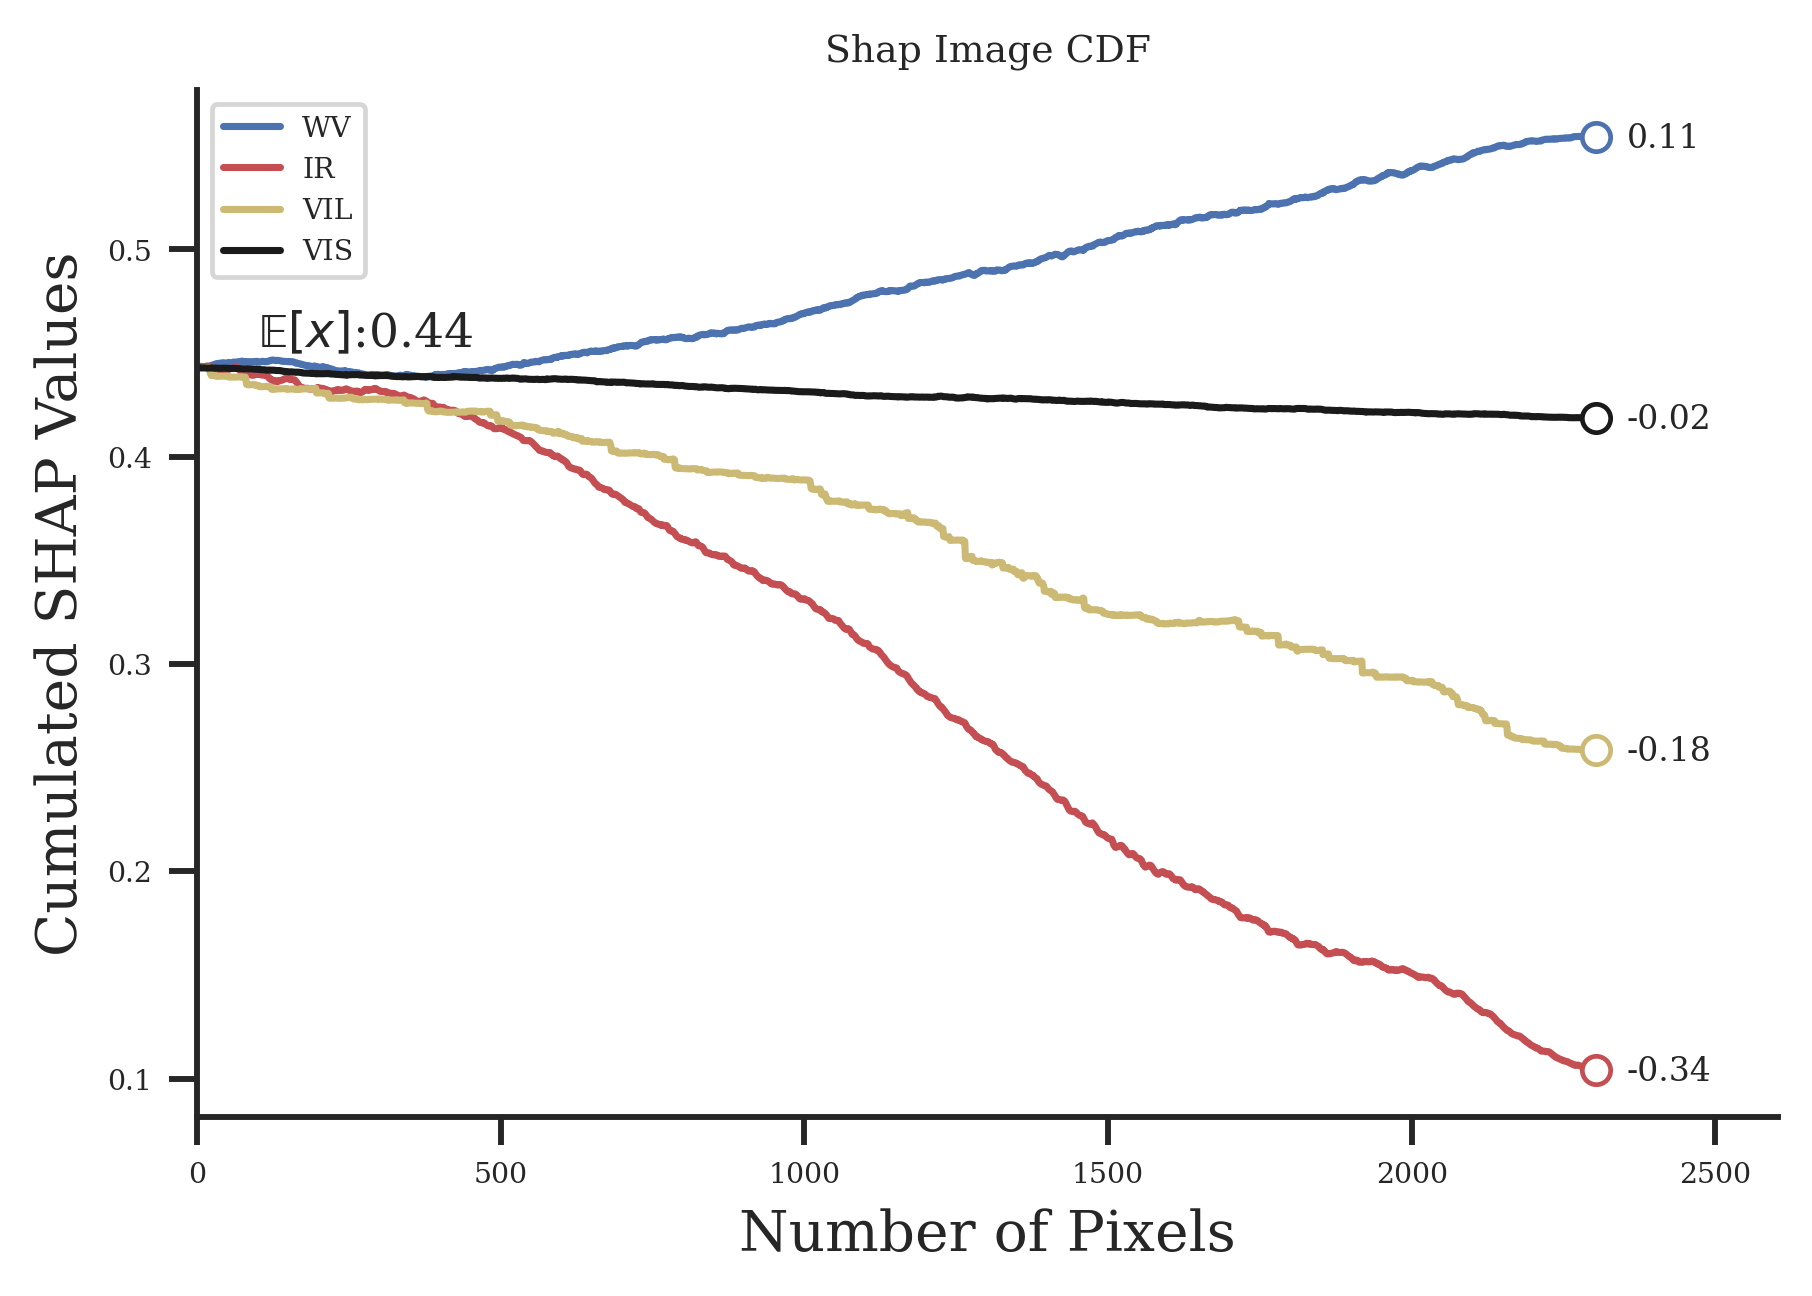

In [19]:
cdf_plot(im, shap_values_class, class_explainer,)

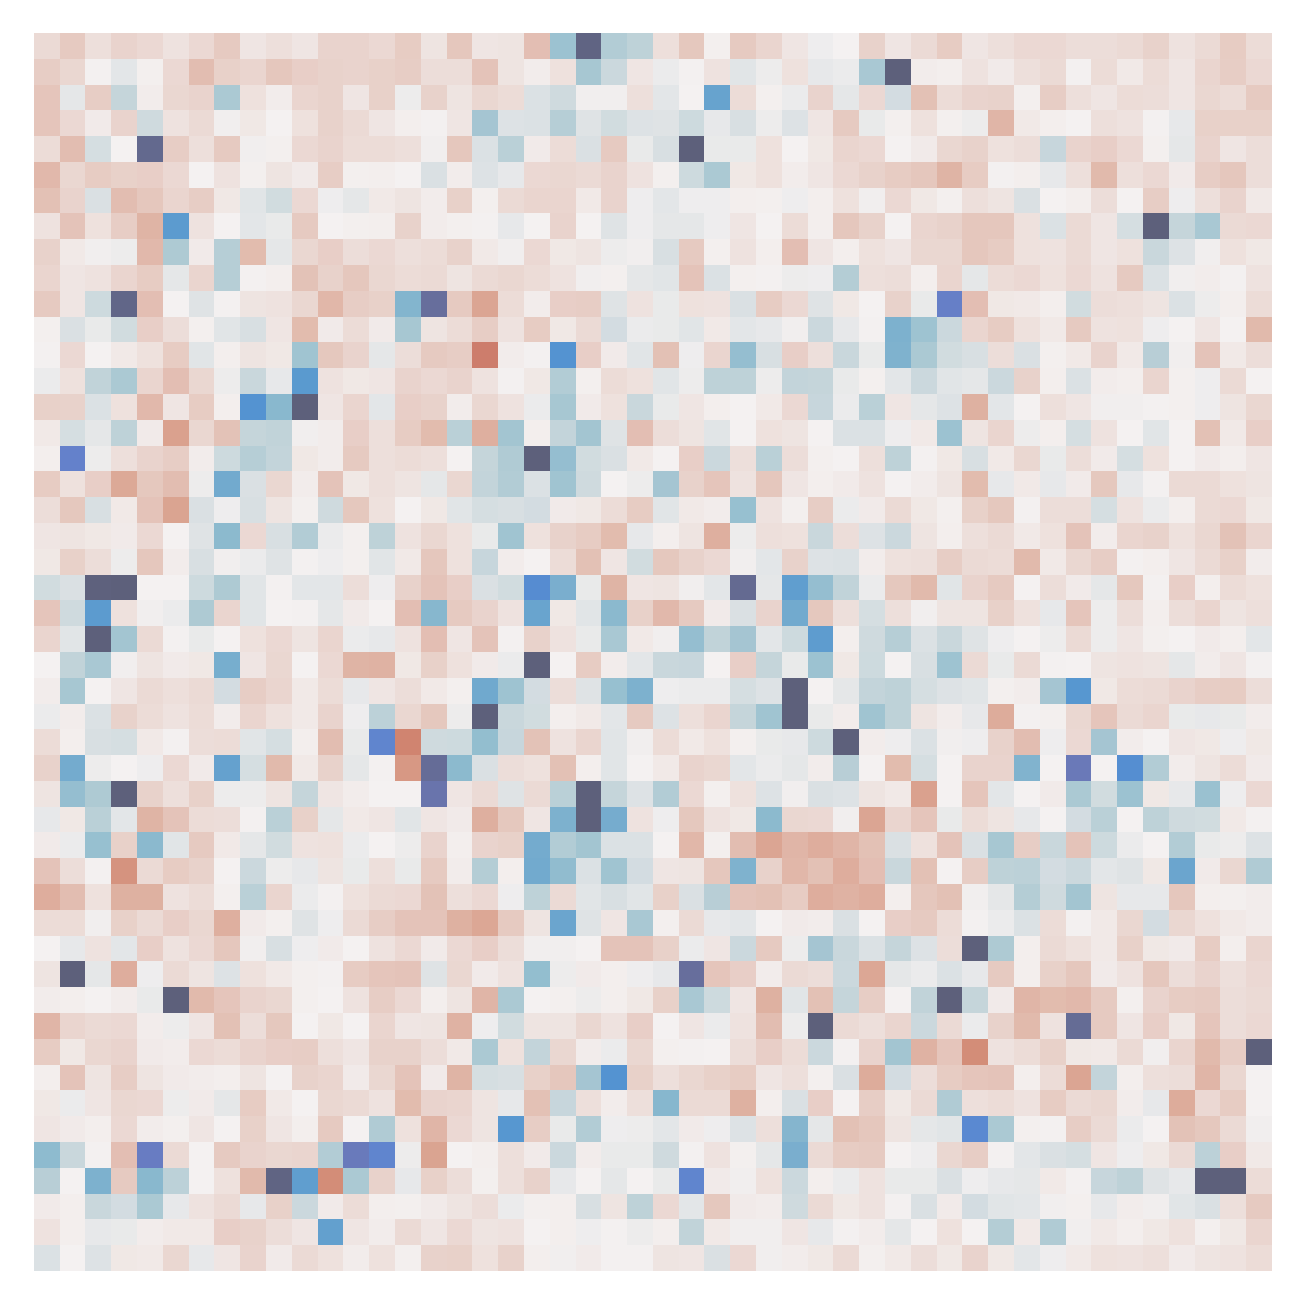

In [20]:
#by default it outputs channelwise results, so here we sum them together
shap_values_summed = np.sum(shap_values_class,axis=-1)
fig,axes = plt.subplots(1,1,figsize=[4, 4], dpi=170)
fig.set_facecolor('w')
mask = standardanom(shap_values_summed)
axes.imshow(mask,cmap=cmocean.cm.balance,alpha=0.7,vmin=-4,vmax=4)
axes.axis('off')
plt.tight_layout()

In [21]:
class_explainer.expected_value + np.sum(shap_values_class)

array([0.00637048], dtype=float32)

### ii. Regression

<div class="alert alert-block alert-warning"><b>Optional Task: </b> Convert the following section back to code and run it to see how the SHAP values compare against the classification model for the same example. </div>

<div class="alert alert-block alert-info"><b>Question 7 (optional): </b> If you did the regression task above, how did it compare against the classifiction model for the same example? Do you find the explanation of the model behavior more or less difficult? </div>

### Summary

In this notebook we showed two case studies *explaining* the deep learning models predictions. One of them was a clear intense storm case with abundant lightning, the other was a cloudy event with no lightning.

### How to select new cases

<div class="alert alert-block alert-warning"><b>Optional Task: </b> Explore different examples in the dataset and use the SHAP values to better understand the models.  </div>


we only showed two examples above, but there are more than 100,000 images to look at in this dataset. To choose a new example you can look up new storms by index if you want. 


<div class="alert alert-block alert-success"><b>User-Defined Options</b> To explore different examples, you'll have to declare the example index (<b>idx</b>) and whether you are using the classification (mode = 'classification') or regression model (mode = 'regression') </div>


In [22]:
# USER-DEFINED OPTIONS ----------------------
idx = 42 
mode = 'classification'
#mode = 'regression'
#--------------------------------------------

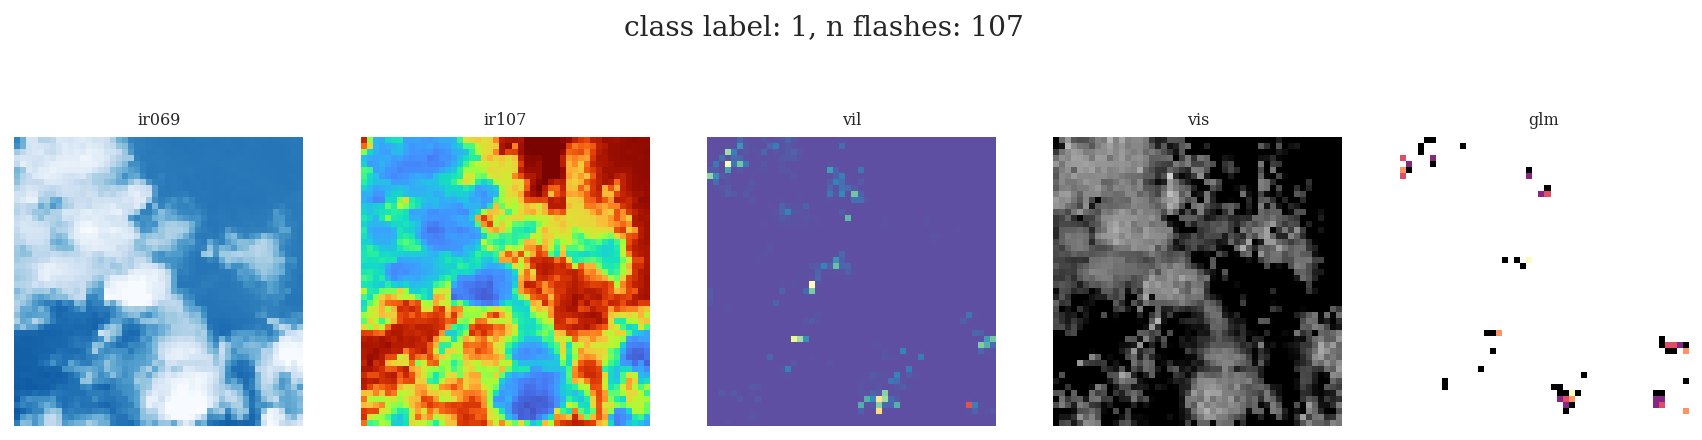

In [23]:
ds_sample = ds_val.isel(n_samples=idx)

#plot this example with a plotter function I have defined 
show_sample(ds_sample)

#store this image to do the XAI on 
im = ds_sample.features.values 

<div class="alert alert-block alert-danger"><b>Caution: </b> The <b>make_plot</b> function relies a user-defined <b>mask_thresh</b> for the SHAP overlays. If you are exploring different examples, you'll likely have to use different thresholds per example.</div>

Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior


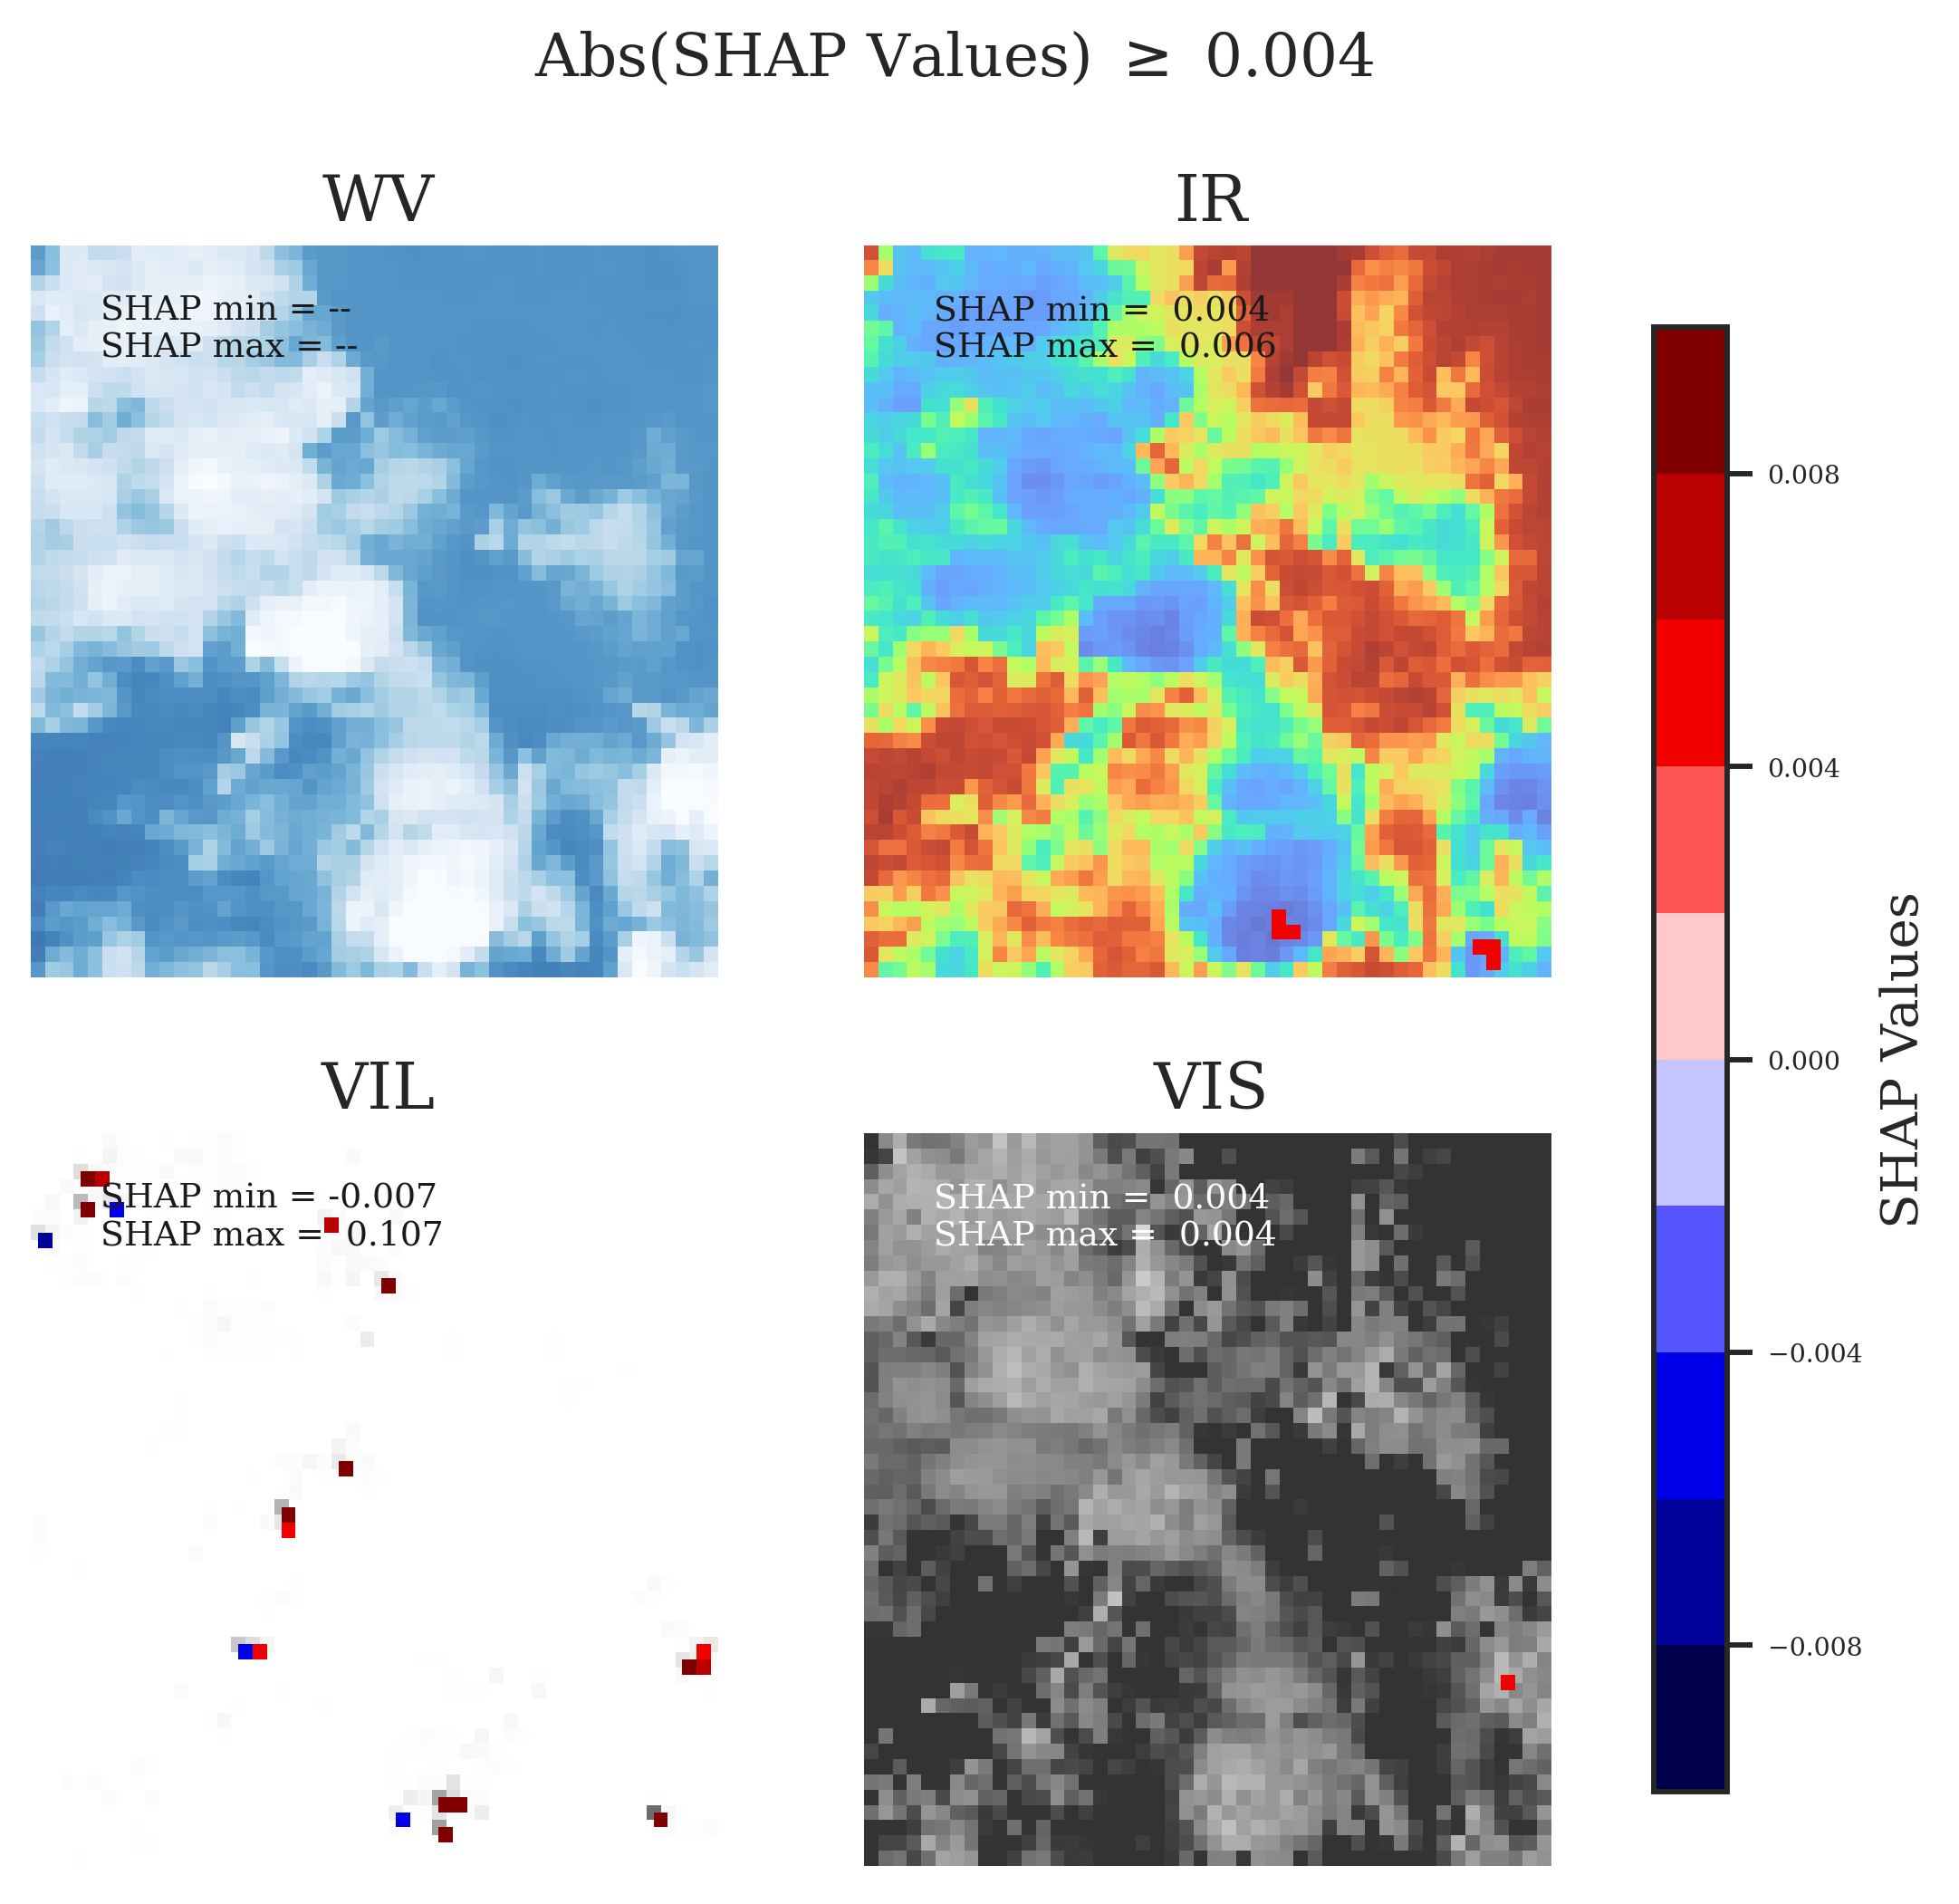

In [24]:
explainer = class_explainer if mode == 'classification' else reg_explainer

shap_values = explainer.shap_values(im[np.newaxis,:,:,:])[0][0]
ax = make_plot(im, mask=shap_values, mask_thresh=0.004, normalize=True)

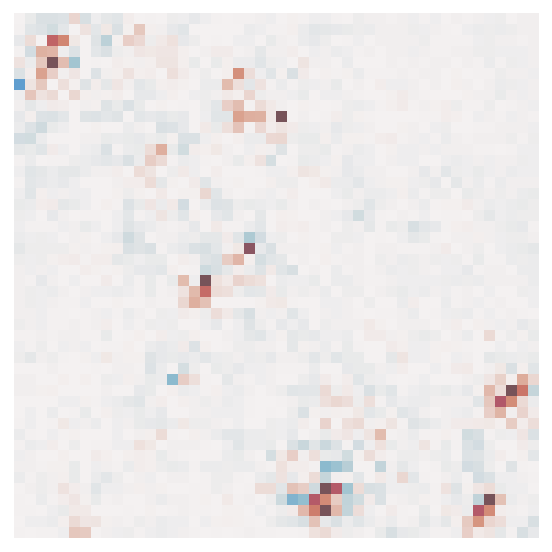

In [25]:
shap_values_summed = np.sum(shap_values,axis=-1)
fig,axes = plt.subplots(1,1,figsize=[4, 4])
fig.set_facecolor('w')
mask = standardanom(shap_values_summed)
axes.imshow(mask,cmap=cmocean.cm.balance,alpha=0.7,vmin=-4,vmax=4)
axes.axis('off')
plt.tight_layout()

This example it seems to be focusing in on the storm to the bottom of the image, which indeed has lightning

Then what if you wanted a different time step of this same 'storm system'

In [26]:
#choose 1 'storm' to show in examples
ds_sample_all_time = ds_val.isel(n_samples=ds_val.groupby('id').groups[str(ds_sample.id.values)])
ds_sample_all_time

<xarray.Dataset>
Dimensions:         (n_samples: 12, x: 48, y: 48, n_channel: 4)
Coordinates:
    id              (n_samples) object 'R19072723347550' ... 'R19072723347550'
  * n_channel       (n_channel) <U5 'ir069' 'ir107' 'vil' 'vis'
  * n_samples       (n_samples) datetime64[ns] 2019-07-26T23:10:00 ... 2019-0...
Dimensions without coordinates: x, y
Data variables:
    features        (n_samples, x, y, n_channel) float32 ...
    label_1d_class  (n_samples) int8 ...
    label_1d_reg    (n_samples) int16 ...
    label_2d_class  (n_samples, x, y) int8 ...
    label_2d_reg    (n_samples, x, y) int16 ...

You can see now there is 12 samples, which are all the time steps of this one storm scene 

divide by zero encountered in log10


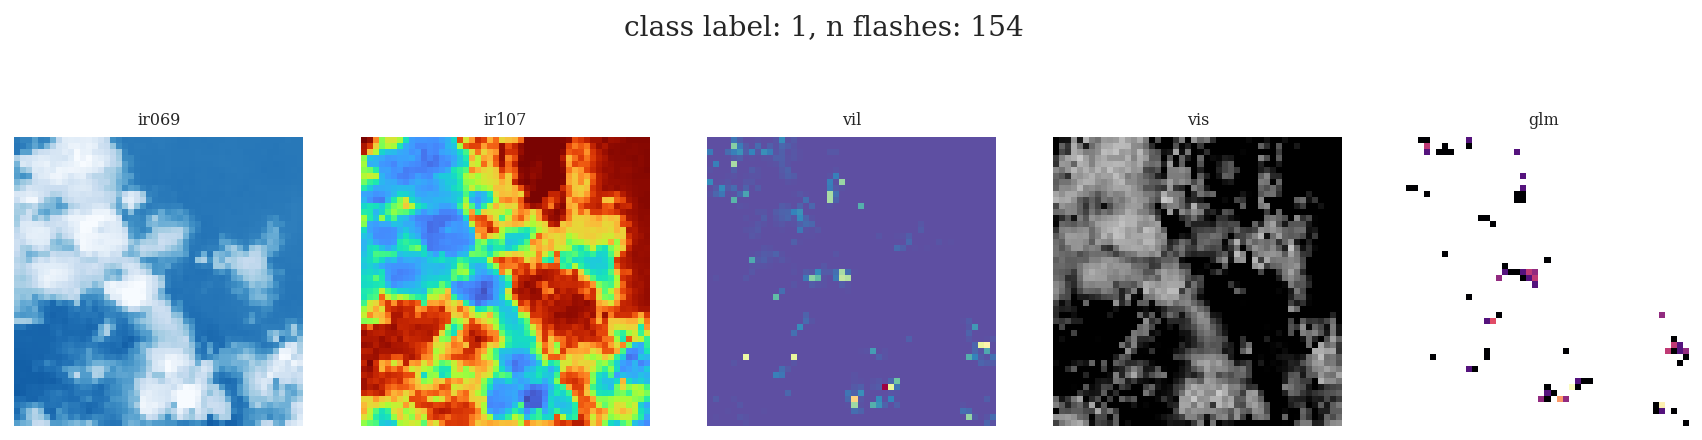

In [27]:
#plot this example with a plotter function I have defined 
show_sample(ds_sample_all_time.isel(n_samples=0))

#store this image to do the XAI on 
im = ds_sample_all_time.isel(n_samples=0).features.values 